In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from geopy.geocoders import Nominatim
import time
from datetime import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
def df_concat(*file_name):
    # concatenates multiple files in a single df
    df_f = pd.DataFrame()
    for i in file_name:
        df_file = pd.read_csv(f'{i}.csv', index_col = 0)
        df_f = pd.concat([df_f, df_file])
    
    # removing duplicated listings
    df_size_with_dups = df_f.shape[0]
    df_f = df_f.drop_duplicates(subset=['url'],keep='last')
    print(f'There are {df_size_with_dups - df_f.shape[0]} duplicates.')
    df_f = df_f.reset_index(drop=True)
    return df_f

In [3]:
df = df_concat('apt_house_sfbay_2023-02-24', 'apt_house_sfbay_2023-03-06', 'apt_house_sfbay_2023-03-19')
df_org_size = df.shape[0] # saves the initial number of rows

There are 1776 duplicates.


In [4]:
# pd.set_option('display.max_colwidth', None)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   url                    18183 non-null  object 
 1   price                  18183 non-null  object 
 2   area                   18183 non-null  object 
 3   location               18183 non-null  object 
 4   latitude               18183 non-null  float64
 5   longitude              18183 non-null  float64
 6   bedrooms               18183 non-null  int64  
 7   bathrooms              18183 non-null  object 
 8   description            18183 non-null  object 
 9   property_type          18182 non-null  object 
 10  parking                18183 non-null  object 
 11  laundry                18183 non-null  object 
 12  rent_period            18183 non-null  object 
 13  EV_charging            18183 non-null  int64  
 14  air_conditioning       18183 non-null  int64  
 15  fu

In [6]:
df.head()

,url,price,area,location,latitude,longitude,bedrooms,bathrooms,description,property_type,...,rent_period,EV_charging,air_conditioning,furnished,smoking,wheelchair_accessible,cats_allowed,dogs_allowed,room_type,bath_type
0,https://sfbay.craigslist.org/sby/apa/d/sunnyva...,3166,- 811ft,sunnyvale,37.398686,-122.012776,1,1,"['QR Code Link to This Post', 'Call Now -', 's...",apartment,...,monthly,1,1,0,0,1,1,1,NaN,NaN
1,https://sfbay.craigslist.org/sby/apa/d/san-jos...,1874,/ 410ft,san jose east,37.319764,-121.823586,0,1,"['QR Code Link to This Post', 'Lion Villas', '...",apartment,...,monthly,0,1,0,1,0,1,1,NaN,NaN
2,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2195,/ 550ft,downtown / civic / van ness,37.791700,-122.418600,0,1,"['QR Code Link to This Post', ""601 O'farrell #...",apartment,...,monthly,0,0,0,1,0,1,1,NaN,NaN
3,https://sfbay.craigslist.org/sby/apa/d/mountai...,3095,- 947ft,mountain view,37.389300,-122.078300,2,2,"['QR Code Link to This Post', 'Find the Perfec...",apartment,...,monthly,0,0,0,0,0,1,1,NaN,NaN
4,https://sfbay.craigslist.org/nby/apa/d/sebasto...,1250,/ 400ft,sebastopol,38.394100,-122.843300,0,1,"['QR Code Link to This Post', 'Sebastopol stud...",cottage/cabin,...,monthly,0,0,0,0,0,0,0,NaN,NaN


In [7]:
# The features "room_type" and "bath_type" are used only in listings for rooms in shared properties,
# so we will drop them.
df = df.drop(['room_type', 'bath_type'], axis=1)

#### Cleaning column "price"

In [8]:
df_p = df.copy()

In [9]:
df_p = df_p[df_p['price'].str.isalnum()]
df_p['price'] = df_p['price'].astype(int)

#### Dealing with outliers in column "price"

In [10]:
# Check if we have enough listing for "weekly" and "daily" rent period, or we should drop them
print(f"The number of weekly rent listings is {df_p[df_p['rent_period'] == 'weekly'].shape[0]}")
print(f"The number of daily rent listings is {df_p[df_p['rent_period'] == 'daily'].shape[0]}")

The number of weekly rent listings is 10
The number of daily rent listings is 153


In [11]:
# There is no enugh daily and weekly listing, and their price is significamtly lower than the
# daily and monthly listings, and they are gonna negatively impact the model, so we should drop them
idx_rent_period = df_p[(df_p['rent_period'] == 'weekly') | (df_p['rent_period'] == 'daily')].index
df_p = df_p.drop(idx_rent_period)

# And let's drop the entire column since we have only one value
df_p = df_p.drop('rent_period', axis=1)

<AxesSubplot:ylabel='price'>

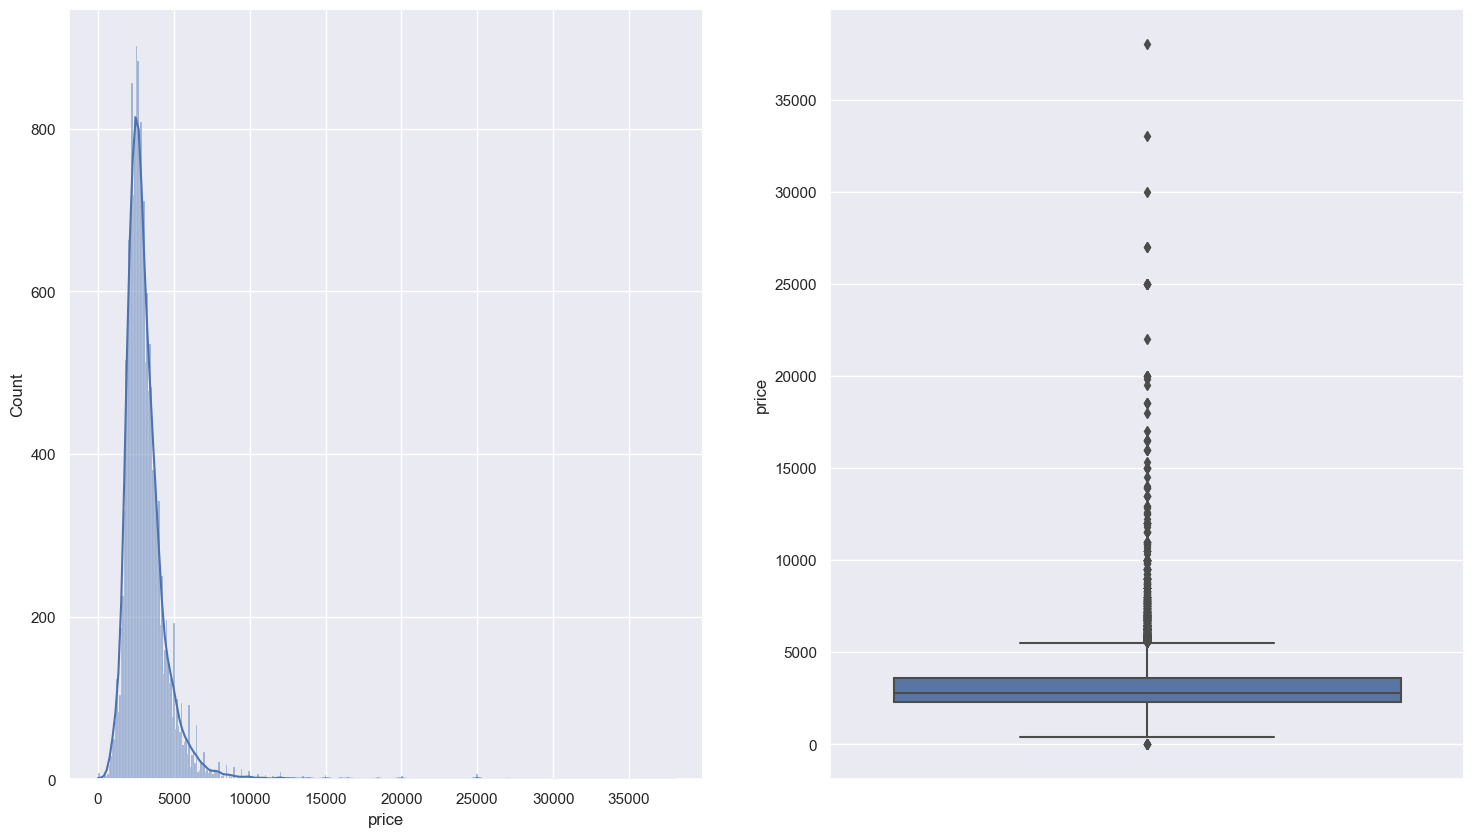

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10), squeeze=False)
sns.histplot(ax=axes[0,0], data=df_p, x='price', kde=True)
sns.boxplot(ax=axes[0,1], data=df_p, y='price')
# sns.histplot(ax=axes[0,1], data=df, x='price')

In [13]:
def extract_outliers_perntile(df, column, upper=95, lower=5):
    # extract the outliers beyond percentiles
    q_upper, q_lower = np.percentile(df[column], q=[upper,lower])
    
    df_percentile = df[(df[column] < q_lower) | (df[column] > q_upper)]
    print(f'The lower value limit is {q_lower}, and the upper is {q_upper}.\
There are {df_percentile.shape[0]}.')
    return df_percentile

In [14]:
outliers = extract_outliers_perntile(df_p, 'price', 98, 2)

The lower value limit is 1284.0, and the upper is 6698.399999999998.There are 720.


In [15]:
df_p = df_p.drop(outliers.index)
print(f'{len(outliers)} outliers were droped from the "price" feature')

720 outliers were droped from the "price" feature


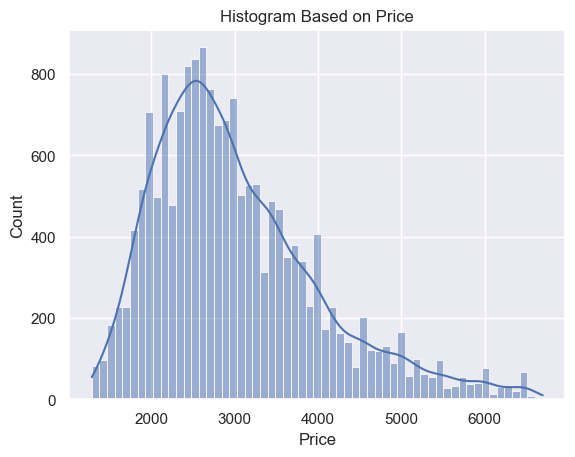

In [16]:
sns.histplot(data=df_p, x='price', kde=True)
plt.title('Histogram Based on Price')
plt.xlabel('Price')
plt.ticklabel_format(style='plain', axis='x') # supresses scientific notation

#### Dealing with the "bathroom" column

In [17]:
def linear_regression_plot(df_f, x, y, up_intercept=2000, low_intercept=2000,
                           up_slope=0, low_slope=0):
    """
    This function returns the outliers of the linear correlation of two dataframe features 
    x and y. It also draws offset lower and upper lines to visually represent the outliers, 
    which are located above and below these lines. 
    
    up_intercept, low_intercept: (integer, integer)
        The offset of the intercept.
        
    up_slope, low_slope: (float, float)
        The offset of the slope.
    """
    
    from scipy.stats import linregress
    reg = linregress(df_f[x], df_f[y])
    print(f'The intercept is {reg.intercept}, and the slope is {reg.slope}')
    
    up_slope_offset = (reg.slope + up_slope)
    up_intercept_offset = reg.intercept + up_intercept
    low_slope_offset = (reg.slope - low_slope)
    low_intercept_offset = reg.intercept - low_intercept
    
    plt.axline((0, up_intercept_offset), slope=up_slope_offset, c='r')
    plt.axline((0, low_intercept_offset), slope=low_slope_offset, c='r')
    
    sns.regplot(data=df_f,x=x, y=y)
    plt.xlim(0 ,df_f[x].max() + np.percentile(df_f[x], 5))
    plt.ylim(0 ,df_f[y].max() + np.percentile(df_f[y], 5));
    
    outliers = []
    for i in (df_f.index):
        if ((up_slope_offset * df_f.loc[i,x] + up_intercept_offset) <
            (df_f.loc[i,y])):
            outliers.append(i)
        elif ((low_slope_offset * df_f.loc[i,x] + low_intercept_offset) >
            (df_f.loc[i,y])):
            outliers.append(i)
        
    print(f'There are {len(outliers)} outliers.')    
    return outliers

In [18]:
df = df_p.copy()
df_bth = df.copy()

In [19]:
print(f'The unique values in the "bathroom" feature are: \n\n{df_bth.bathrooms.value_counts()}')

The unique values in the "bathroom" feature are: 

1         11656
2          4256
1.5         637
2.5         402
3           212
split        45
3.5          26
shared       26
5            13
4            13
4.5           2
6             2
9+            1
Name: bathrooms, dtype: int64


In [20]:
# Based on my research, if the bathroom is "shared", then the listing is for a room in a shared property.
# "split" or "1.5" means a bathroom and a separate restroom, so we can assign 1.5 for split.
# A value of "9+" is an outlier compare to the other numbers, and we have only 2, so we will drop them.
idx_bath = df_bth[(df_bth['bathrooms'] == 'shared') | (df_bth['bathrooms'] == '9+')].index
df_bth = df_bth.drop(idx_bath)
print(f'Dropping {len(idx_bath)} rows')

df_bth['bathrooms'] = df_bth['bathrooms'].replace('split', 1.5)
df_bth['bathrooms'] = df_bth['bathrooms'].astype(float)

Dropping 27 rows


The intercept is 1619.731694873156, and the slope is 1044.7636277572453
There are 34 outliers.


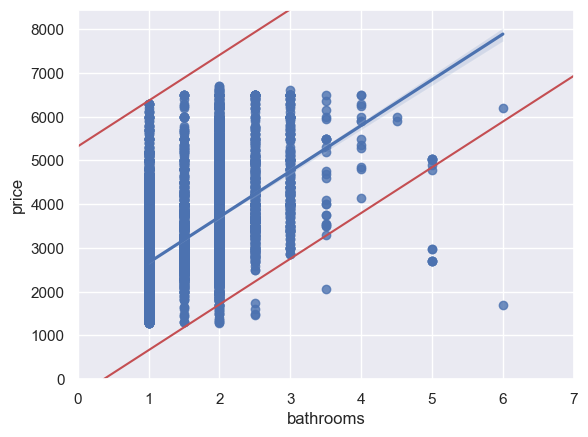

In [21]:
# listings with low price and more than one bathrooms are rooms in a shared property
outliers = linear_regression_plot(df_bth, 'bathrooms', 'price', 3700, 2000, 0, 0)

In [22]:
df_bth = df_bth.drop(outliers) # dropping the above outliers

The intercept is 1574.8878786879634, and the slope is 1082.4183348301244
There are 2 outliers.


[12729, 16282]

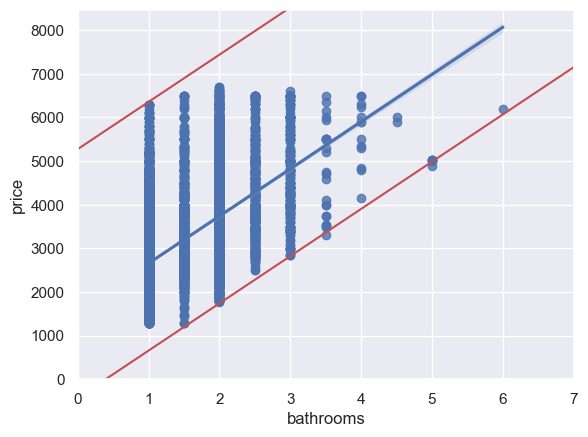

In [23]:
linear_regression_plot(df_bth, 'bathrooms', 'price', 3700, 2000, 0, 0)

#### Dealing with bedrooms

In [24]:
df = df_bth.copy()
df_br = df.copy()

In [25]:
print(f'The unique values in the "bedrooms" feature are: \n\n{df_br.bedrooms.value_counts()}')

The unique values in the "bedrooms" feature are: 

1    6826
2    6494
0    1857
3    1671
4     323
5      57
6       2
Name: bedrooms, dtype: int64


The intercept is 1997.5714878563604, and the slope is 665.292143558257
There are 21 outliers.


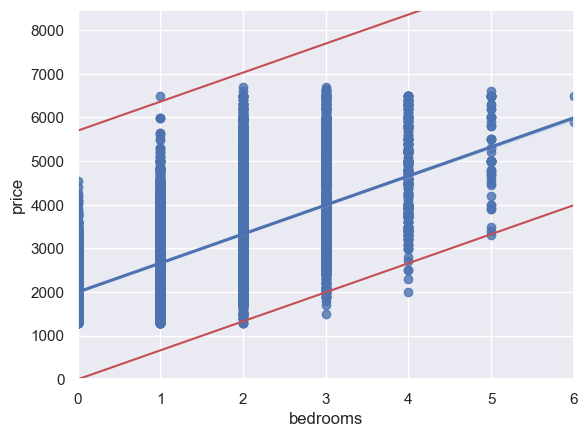

In [26]:
outliers = linear_regression_plot(df_br, 'bedrooms', 'price', 3700, 2000, 0, 0)

In [27]:
df_br = df_br.drop(outliers) # dropping the above outliers

The intercept is 1992.1049598579552, and the slope is 670.3514114447862
There are 4 outliers.


[2690, 3086, 13428, 15963]

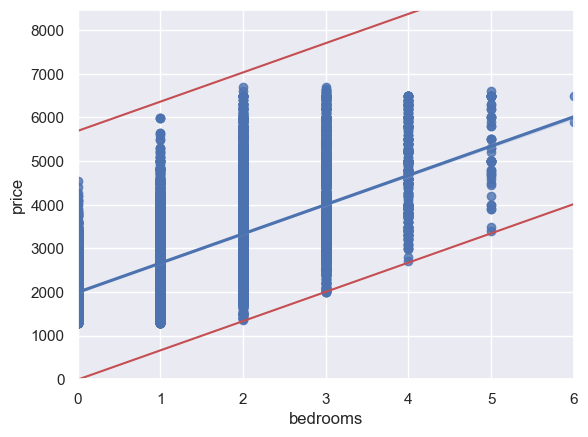

In [28]:
linear_regression_plot(df_br, 'bedrooms', 'price', 3700, 2000, 0, 0)

#### Dealing with location

In [29]:
df = df_br.copy()
df_loc = df.copy()
df_loc = df_loc.reset_index(drop=True)

In [30]:
geolocator = Nominatim(user_agent="geoapiExercises")

In [31]:
# Getting the city, neighborhood, zip code and state based on GPS location.
# A good internet connection is recommended
# !!!This step might take up to several hours!!!
unconverted_location = []
for i in (df_loc.index):
    try:
        raw = geolocator.reverse(str(df_loc.loc[i,'latitude'])+","+str(df_loc.loc[i,'longitude'])).raw
        
        if 'town' in raw['address'].keys():
            df_loc.loc[i, 'city'] = raw['address']['town']
        elif 'city' in raw['address'].keys():
            df_loc.loc[i, 'city'] = raw['address']['city']

        if 'neighbourhood' in raw['address'].keys():
            df_loc.loc[i, 'neighbourhood'] = raw['address']['neighbourhood']

        if 'postcode' in raw['address'].keys():
            df_loc.loc[i, 'zip_code'] = raw['address']['postcode']

        if 'state' in raw['address'].keys():
            df_loc.loc[i, 'state'] = raw['address']['state']
            
        print(f"{i} out of {df_loc.shape[0]}, city: {df_loc.loc[i, 'city']}, state: \
{df_loc.loc[i, 'state']}, zip code: {df_loc.loc[i, 'zip_code']}")    
        time.sleep(1)
    
    except:
        unconverted_location.append(i)
        print(f'Index {i} did not get converted')
print(f'The location of {len(unconverted_location)} listings did not get converted')
if len(unconverted_location) > df_loc.shape[0] * 0.005:
    print('It is advised to run this cell again')

0 out of 17209, city: Sunnyvale, state: California, zip code: 94089
1 out of 17209, city: San Jose, state: California, zip code: 95122
2 out of 17209, city: San Francisco, state: California, zip code: 94164
3 out of 17209, city: Mountain View, state: California, zip code: 94041
4 out of 17209, city: Fremont, state: California, zip code: 94536
5 out of 17209, city: San Jose, state: California, zip code: 95117
6 out of 17209, city: San Francisco, state: California, zip code: 94102
7 out of 17209, city: Hercules, state: California, zip code: 94547
8 out of 17209, city: Sunnyvale, state: California, zip code: 94087
9 out of 17209, city: San Jose, state: California, zip code: 95122
10 out of 17209, city: Oakland, state: California, zip code: 94607
11 out of 17209, city: San Francisco, state: California, zip code: 90214
12 out of 17209, city: Rohnert Park, state: California, zip code: 94928
13 out of 17209, city: Santa Clara, state: California, zip code: 95051
14 out of 17209, city: Livermor

118 out of 17209, city: San Mateo, state: California, zip code: 94401
119 out of 17209, city: Martinez, state: California, zip code: 94553
120 out of 17209, city: Fremont, state: California, zip code: 94536
121 out of 17209, city: Berkeley, state: California, zip code: 94704
122 out of 17209, city: Benicia, state: California, zip code: 94510
123 out of 17209, city: San Jose, state: California, zip code: 95121
124 out of 17209, city: Pleasanton, state: California, zip code: 94566
125 out of 17209, city: San Francisco, state: California, zip code: 94164
126 out of 17209, city: Berkeley, state: California, zip code: 94705
127 out of 17209, city: San Francisco, state: California, zip code: 94115
128 out of 17209, city: Dublin, state: California, zip code: 94568
129 out of 17209, city: San Francisco, state: California, zip code: 94108
130 out of 17209, city: El Cerrito, state: California, zip code: 94530
131 out of 17209, city: Vallejo, state: California, zip code: 94590
132 out of 17209, c

235 out of 17209, city: San Francisco, state: California, zip code: 94102
236 out of 17209, city: San Francisco, state: California, zip code: 94107
237 out of 17209, city: San Francisco, state: California, zip code: 41907
238 out of 17209, city: Berkeley, state: California, zip code: 94703
239 out of 17209, city: Newark, state: California, zip code: 94560
240 out of 17209, city: Pleasanton, state: California, zip code: 94566
241 out of 17209, city: San Francisco, state: California, zip code: 94114
242 out of 17209, city: San Francisco, state: California, zip code: 94102
243 out of 17209, city: Hayward, state: California, zip code: 94544
244 out of 17209, city: Cupertino, state: California, zip code: 95014
245 out of 17209, city: San Francisco, state: California, zip code: 94102
246 out of 17209, city: Foster City, state: California, zip code: 94404
247 out of 17209, city: San Bruno, state: California, zip code: 94066
248 out of 17209, city: Campbell, state: California, zip code: 95008


351 out of 17209, city: San Francisco, state: California, zip code: 94103
352 out of 17209, city: Santa Rosa, state: California, zip code: 95401
353 out of 17209, city: Sunnyvale, state: California, zip code: 94086
354 out of 17209, city: Richmond, state: California, zip code: 94801
355 out of 17209, city: Larkspur, state: California, zip code: 94964
356 out of 17209, city: San Jose, state: California, zip code: 95126
357 out of 17209, city: Hayward, state: California, zip code: 25426
358 out of 17209, city: Richmond, state: California, zip code: 94801
359 out of 17209, city: Milpitas, state: California, zip code: 95035
360 out of 17209, city: San Jose, state: California, zip code: 95113
361 out of 17209, city: San Jose, state: California, zip code: 95125
362 out of 17209, city: Santa Rosa, state: California, zip code: 95404
363 out of 17209, city: San Bruno, state: California, zip code: 94066
364 out of 17209, city: San Jose, state: California, zip code: 95128
365 out of 17209, city: 

469 out of 17209, city: San Francisco, state: California, zip code: 94102
470 out of 17209, city: Livermore, state: California, zip code: 94551
471 out of 17209, city: San Francisco, state: California, zip code: 94164
472 out of 17209, city: Fremont, state: California, zip code: 94536
473 out of 17209, city: San Francisco, state: California, zip code: 94164
474 out of 17209, city: San Francisco, state: California, zip code: 94102
475 out of 17209, city: Pleasanton, state: California, zip code: 94566
476 out of 17209, city: San Francisco, state: California, zip code: 94017
477 out of 17209, city: Fremont, state: California, zip code: 94536
478 out of 17209, city: Oakland, state: California, zip code: 94610
479 out of 17209, city: nan, state: California, zip code: 95003
480 out of 17209, city: San Mateo, state: California, zip code: 94402
481 out of 17209, city: Pleasanton, state: California, zip code: 94566
482 out of 17209, city: Mountain View, state: California, zip code: 94041
483 ou

586 out of 17209, city: Campbell, state: California, zip code: 95008
587 out of 17209, city: San Francisco, state: California, zip code: 94121
588 out of 17209, city: San Francisco, state: California, zip code: 94164
589 out of 17209, city: Oakland, state: California, zip code: 94612
590 out of 17209, city: Campbell, state: California, zip code: 95008
591 out of 17209, city: San Francisco, state: California, zip code: 94116
592 out of 17209, city: Dublin, state: California, zip code: 94568
593 out of 17209, city: Sunnyvale, state: California, zip code: 94087
594 out of 17209, city: Redwood City, state: California, zip code: 94063
595 out of 17209, city: Santa Rosa, state: California, zip code: 95405
596 out of 17209, city: San Jose, state: California, zip code: 95120
597 out of 17209, city: Richmond, state: California, zip code: 94801
598 out of 17209, city: San Francisco, state: California, zip code: 94103
599 out of 17209, city: Berkeley, state: California, zip code: 94608
600 out of

702 out of 17209, city: San Jose, state: California, zip code: 95131
703 out of 17209, city: San Rafael, state: California, zip code: 94901
704 out of 17209, city: Martinez, state: California, zip code: 94553
705 out of 17209, city: Rohnert Park, state: California, zip code: 94926
706 out of 17209, city: San Jose, state: California, zip code: 95128
707 out of 17209, city: Castro Valley, state: California, zip code: 94546
708 out of 17209, city: San Francisco, state: California, zip code: 94118
709 out of 17209, city: San Jose, state: California, zip code: 95112
710 out of 17209, city: Cupertino, state: California, zip code: 95014
711 out of 17209, city: Santa Rosa, state: California, zip code: 95405
712 out of 17209, city: San Jose, state: California, zip code: 95122
713 out of 17209, city: Sunnyvale, state: California, zip code: 94085
714 out of 17209, city: nan, state: California, zip code: 94506
715 out of 17209, city: San Jose, state: California, zip code: 95126
716 out of 17209, c

819 out of 17209, city: American Canyon, state: California, zip code: 94503
820 out of 17209, city: San Francisco, state: California, zip code: 94143
821 out of 17209, city: Richmond, state: California, zip code: 94804
822 out of 17209, city: Berkeley, state: California, zip code: 94701
823 out of 17209, city: San Francisco, state: California, zip code: 94111
824 out of 17209, city: Live Oak, state: California, zip code: 95062
825 out of 17209, city: Hayward, state: California, zip code: 25426
826 out of 17209, city: San Francisco, state: California, zip code: 94017
827 out of 17209, city: Palo Alto, state: California, zip code: 94306
828 out of 17209, city: San Francisco, state: California, zip code: 94118
829 out of 17209, city: San Jose, state: California, zip code: 95132
830 out of 17209, city: Sunnyvale, state: California, zip code: 94086
831 out of 17209, city: San Francisco, state: California, zip code: 94102
832 out of 17209, city: San Francisco, state: California, zip code: 94

935 out of 17209, city: San Leandro, state: California, zip code: 94578
936 out of 17209, city: San Rafael, state: California, zip code: 94901
937 out of 17209, city: San Francisco, state: California, zip code: 94116
938 out of 17209, city: San Francisco, state: California, zip code: 94158
939 out of 17209, city: Berkeley, state: California, zip code: 94720
940 out of 17209, city: San Jose, state: California, zip code: 95132
941 out of 17209, city: Sunnyvale, state: California, zip code: 94086
942 out of 17209, city: Walnut Creek, state: California, zip code: 94596
943 out of 17209, city: San Francisco, state: California, zip code: nan
944 out of 17209, city: Alameda, state: California, zip code: 94501
945 out of 17209, city: Alameda, state: California, zip code: 94501
946 out of 17209, city: Pleasanton, state: California, zip code: 94588
947 out of 17209, city: Milpitas, state: California, zip code: 95035
948 out of 17209, city: San Francisco, state: California, zip code: 90214
949 ou

1050 out of 17209, city: San Francisco, state: California, zip code: 94115
1051 out of 17209, city: San Francisco, state: California, zip code: 94122
1052 out of 17209, city: San Jose, state: California, zip code: 95119
1053 out of 17209, city: Walnut Creek, state: California, zip code: 94596
1054 out of 17209, city: Berkeley, state: California, zip code: 94710
1055 out of 17209, city: Castro Valley, state: California, zip code: 94546
1056 out of 17209, city: Lafayette, state: California, zip code: 94706
1057 out of 17209, city: Oakland, state: California, zip code: 94601
1058 out of 17209, city: San Francisco, state: California, zip code: 94105
1059 out of 17209, city: El Cerrito, state: California, zip code: 94530
1060 out of 17209, city: Vallejo, state: California, zip code: 94525
1061 out of 17209, city: Portland, state: Oregon, zip code: 97232
1062 out of 17209, city: San Francisco, state: California, zip code: 94102
1063 out of 17209, city: San Jose, state: California, zip code: 

1165 out of 17209, city: San Francisco, state: California, zip code: 94108
1166 out of 17209, city: Santa Clara, state: California, zip code: 95051
1167 out of 17209, city: San Francisco, state: California, zip code: 94123
1168 out of 17209, city: Foster City, state: California, zip code: 94404
1169 out of 17209, city: Castro Valley, state: California, zip code: 94546
1170 out of 17209, city: San Francisco, state: California, zip code: 94164
1171 out of 17209, city: Fairfield, state: California, zip code: 94533
1172 out of 17209, city: San Leandro, state: California, zip code: 94578
1173 out of 17209, city: Vallejo, state: California, zip code: 94590
1174 out of 17209, city: Vallejo, state: California, zip code: 94590
1175 out of 17209, city: Milpitas, state: California, zip code: 95035
1176 out of 17209, city: Berkeley, state: California, zip code: 94703
1177 out of 17209, city: San Jose, state: California, zip code: 95110
1178 out of 17209, city: San Francisco, state: California, zip

1279 out of 17209, city: San Francisco, state: California, zip code: 94122
1280 out of 17209, city: San Francisco, state: California, zip code: 94164
1281 out of 17209, city: San Francisco, state: California, zip code: 94121
1282 out of 17209, city: Berkeley, state: California, zip code: 94705
1283 out of 17209, city: nan, state: California, zip code: 94707
1284 out of 17209, city: San Francisco, state: California, zip code: 41907
1285 out of 17209, city: Richmond, state: California, zip code: 94806
1286 out of 17209, city: San Francisco, state: California, zip code: 94105
1287 out of 17209, city: San Francisco, state: California, zip code: 94134
1288 out of 17209, city: Oakland, state: California, zip code: 94609
1289 out of 17209, city: Redwood City, state: California, zip code: 94063
1290 out of 17209, city: San Francisco, state: California, zip code: 90103
1291 out of 17209, city: Richmond, state: California, zip code: 94803
1292 out of 17209, city: San Ramon, state: California, zi

1393 out of 17209, city: Palo Alto, state: California, zip code: 94301
1394 out of 17209, city: Sausalito, state: California, zip code: 94965
1395 out of 17209, city: San Jose, state: California, zip code: 95112
1396 out of 17209, city: Campbell, state: California, zip code: 95008
1397 out of 17209, city: San Francisco, state: California, zip code: 94108
1398 out of 17209, city: San Francisco, state: California, zip code: 90103
1399 out of 17209, city: Fremont, state: California, zip code: 94536
1400 out of 17209, city: San Jose, state: California, zip code: 95125
1401 out of 17209, city: San Jose, state: California, zip code: 95014
1402 out of 17209, city: Foster City, state: California, zip code: 94404
1403 out of 17209, city: Campbell, state: California, zip code: 95008
1404 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
1405 out of 17209, city: Capitola, state: California, zip code: 95010
1406 out of 17209, city: Vallejo, state: California, zip code: 94590
14

1508 out of 17209, city: San Francisco, state: California, zip code: 90103
1509 out of 17209, city: Santa Rosa, state: California, zip code: 95403
1510 out of 17209, city: Walnut Creek, state: California, zip code: 94596
1511 out of 17209, city: Milpitas, state: California, zip code: 95035
1512 out of 17209, city: South San Francisco, state: California, zip code: 94080
1513 out of 17209, city: Dublin, state: California, zip code: 94568
1514 out of 17209, city: Oakland, state: California, zip code: 94615
1515 out of 17209, city: Martinez, state: California, zip code: 94553
1516 out of 17209, city: Santa Clara, state: California, zip code: 95050
1517 out of 17209, city: Livermore, state: California, zip code: 94550
1518 out of 17209, city: San Francisco, state: California, zip code: 90214
1519 out of 17209, city: San Pablo, state: California, zip code: 94806
1520 out of 17209, city: Santa Rosa, state: California, zip code: 95407
1521 out of 17209, city: Walnut Creek, state: California, z

1622 out of 17209, city: Sunnyvale, state: California, zip code: 94807
1623 out of 17209, city: Oakland, state: California, zip code: 94608
1624 out of 17209, city: Oakland, state: California, zip code: 94601
1625 out of 17209, city: San Francisco, state: California, zip code: 94113
1626 out of 17209, city: San Francisco, state: California, zip code: 94108
1627 out of 17209, city: San Francisco, state: California, zip code: 94133
1628 out of 17209, city: Palo Alto, state: California, zip code: 94306
1629 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
1630 out of 17209, city: Fremont, state: California, zip code: 94536
1631 out of 17209, city: San Jose, state: California, zip code: 95128
1632 out of 17209, city: Pittsburg, state: California, zip code: 94565
1633 out of 17209, city: Cupertino, state: California, zip code: 95014
1634 out of 17209, city: San Carlos, state: California, zip code: 94070
1635 out of 17209, city: Fairfield, state: California, zip code: 94

1737 out of 17209, city: Santa Rosa, state: California, zip code: 95405
1738 out of 17209, city: Palo Alto, state: California, zip code: 94303
1739 out of 17209, city: San Francisco, state: California, zip code: 94124
1740 out of 17209, city: San Jose, state: California, zip code: 95136
1741 out of 17209, city: San Jose, state: California, zip code: 95132
1742 out of 17209, city: San Jose, state: California, zip code: 95128
1743 out of 17209, city: San Francisco, state: California, zip code: 94117
1744 out of 17209, city: San Rafael, state: California, zip code: 94901
1745 out of 17209, city: Pittsburg, state: California, zip code: 94565
1746 out of 17209, city: Livermore, state: California, zip code: 94550
1747 out of 17209, city: Fremont, state: California, zip code: 94536
1748 out of 17209, city: San Bruno, state: California, zip code: 94066
1749 out of 17209, city: San Francisco, state: California, zip code: 94115
1750 out of 17209, city: El Cerrito, state: California, zip code: 94

1852 out of 17209, city: San Francisco, state: California, zip code: 94121
1853 out of 17209, city: San Francisco, state: California, zip code: 94123
1854 out of 17209, city: Santa Clara, state: California, zip code: 95050
1855 out of 17209, city: Benicia, state: California, zip code: 94510
1856 out of 17209, city: San Francisco, state: California, zip code: 94103
1857 out of 17209, city: San Francisco, state: California, zip code: 94103
1858 out of 17209, city: San Francisco, state: California, zip code: 94143
1859 out of 17209, city: San Francisco, state: California, zip code: 94164
1860 out of 17209, city: San Francisco, state: California, zip code: 94134
1861 out of 17209, city: Campbell, state: California, zip code: 95008
1862 out of 17209, city: Santa Rosa, state: California, zip code: 95405
1863 out of 17209, city: San Jose, state: California, zip code: 95123
1864 out of 17209, city: San Francisco, state: California, zip code: 94108
1865 out of 17209, city: Hayward, state: Calif

1966 out of 17209, city: San Jose, state: California, zip code: 95126
1967 out of 17209, city: Walnut Creek, state: California, zip code: 94596
1968 out of 17209, city: Alameda, state: California, zip code: 94501
1969 out of 17209, city: San Francisco, state: California, zip code: 94113
1970 out of 17209, city: Lafayette, state: California, zip code: 94549
1971 out of 17209, city: Walnut Creek, state: California, zip code: 94596
1972 out of 17209, city: San Mateo, state: California, zip code: 94403
1973 out of 17209, city: San Francisco, state: California, zip code: 94164
1974 out of 17209, city: San Francisco, state: California, zip code: 94164
1975 out of 17209, city: San Francisco, state: California, zip code: 94109
1976 out of 17209, city: Berkeley, state: California, zip code: 94709
1977 out of 17209, city: San Jose, state: California, zip code: 95126
1978 out of 17209, city: San Jose, state: California, zip code: 95126
1979 out of 17209, city: Santa Clara, state: California, zip 

2081 out of 17209, city: Menlo Park, state: California, zip code: 94301
2082 out of 17209, city: Fremont, state: California, zip code: 94536
2083 out of 17209, city: San Francisco, state: California, zip code: 94158
2084 out of 17209, city: Walnut Creek, state: California, zip code: 94596
2085 out of 17209, city: San Francisco, state: California, zip code: 94114
2086 out of 17209, city: East Palo Alto, state: California, zip code: 94303
2087 out of 17209, city: San Francisco, state: California, zip code: 94117
2088 out of 17209, city: Oakland, state: California, zip code: 94609
2089 out of 17209, city: Concord, state: California, zip code: 94521
2090 out of 17209, city: San Jose, state: California, zip code: 95124
2091 out of 17209, city: San Francisco, state: California, zip code: 94105
2092 out of 17209, city: Campbell, state: California, zip code: 95008
2093 out of 17209, city: Mountain View, state: California, zip code: 94039
2094 out of 17209, city: Los Gatos, state: California, z

2195 out of 17209, city: Oakland, state: California, zip code: 94612
2196 out of 17209, city: San Francisco, state: California, zip code: 94115
2197 out of 17209, city: Foster City, state: California, zip code: 94404
2198 out of 17209, city: San Francisco, state: California, zip code: 94143
2199 out of 17209, city: Sunnyvale, state: California, zip code: 94089
2200 out of 17209, city: Albany, state: California, zip code: 94702
2201 out of 17209, city: Berkeley, state: California, zip code: 94703
2202 out of 17209, city: Alameda, state: California, zip code: 94607
2203 out of 17209, city: San Jose, state: California, zip code: 95128
2204 out of 17209, city: San Francisco, state: California, zip code: 95115
2205 out of 17209, city: Belmont, state: California, zip code: 94002
2206 out of 17209, city: San Leandro, state: California, zip code: 94578
2207 out of 17209, city: Santa Clara, state: California, zip code: 95051
2208 out of 17209, city: Oakland, state: California, zip code: 94612
2

2310 out of 17209, city: Concord, state: California, zip code: 94520
2311 out of 17209, city: Burlingame, state: California, zip code: 94101
2312 out of 17209, city: Fremont, state: California, zip code: 94536
2313 out of 17209, city: Mountain View, state: California, zip code: 94041
2314 out of 17209, city: San Jose, state: California, zip code: 95118
2315 out of 17209, city: Foster City, state: California, zip code: 94404
2316 out of 17209, city: Palo Alto, state: California, zip code: 94301
2317 out of 17209, city: Livermore, state: California, zip code: 94551
2318 out of 17209, city: San Francisco, state: California, zip code: 94129
2319 out of 17209, city: San Francisco, state: California, zip code: 94131
2320 out of 17209, city: San Francisco, state: California, zip code: 94121
2321 out of 17209, city: San Francisco, state: California, zip code: nan
2322 out of 17209, city: Mountain View, state: California, zip code: 94041
2323 out of 17209, city: Foster City, state: California, 

2425 out of 17209, city: San Francisco, state: California, zip code: 90214
2426 out of 17209, city: Santa Clara, state: California, zip code: 95054
2427 out of 17209, city: nan, state: California, zip code: 94803
2428 out of 17209, city: Rohnert Park, state: California, zip code: 94928
2429 out of 17209, city: San Mateo, state: California, zip code: 94403
2430 out of 17209, city: Bay Point, state: California, zip code: nan
2431 out of 17209, city: San Francisco, state: California, zip code: 94115
2432 out of 17209, city: San Francisco, state: California, zip code: 94108
2433 out of 17209, city: San Francisco, state: California, zip code: 94117
2434 out of 17209, city: San Francisco, state: California, zip code: 94118
2435 out of 17209, city: Oakland, state: California, zip code: 94612
2436 out of 17209, city: Oakland, state: California, zip code: 94610
2437 out of 17209, city: Fremont, state: California, zip code: 94536
2438 out of 17209, city: San Jose, state: California, zip code: 95

2540 out of 17209, city: Walnut Creek, state: California, zip code: 94596
2541 out of 17209, city: San Leandro, state: California, zip code: 94578
2542 out of 17209, city: Mountain View, state: California, zip code: 94041
2543 out of 17209, city: Emeryville, state: California, zip code: 94608
2544 out of 17209, city: Dublin, state: California, zip code: 94568
2545 out of 17209, city: San Jose, state: California, zip code: 95134
2546 out of 17209, city: San Francisco, state: California, zip code: 94121
2547 out of 17209, city: Oakland, state: California, zip code: 94612
2548 out of 17209, city: Oakland, state: California, zip code: 94612
2549 out of 17209, city: Vallejo, state: California, zip code: 94525
2550 out of 17209, city: San Jose, state: California, zip code: 95117
2551 out of 17209, city: Mountain View, state: California, zip code: 94040
2552 out of 17209, city: San Francisco, state: California, zip code: 94118
2553 out of 17209, city: San Francisco, state: California, zip cod

2654 out of 17209, city: Oakland, state: California, zip code: 94612
2655 out of 17209, city: San Mateo, state: California, zip code: 94401
2656 out of 17209, city: Berkeley, state: California, zip code: 94705
2657 out of 17209, city: Portland, state: Oregon, zip code: 97232
2658 out of 17209, city: San Leandro, state: California, zip code: 94577
2659 out of 17209, city: Danville, state: California, zip code: 94526
2660 out of 17209, city: Martinez, state: California, zip code: 94553
2661 out of 17209, city: San Francisco, state: California, zip code: 94121
2662 out of 17209, city: Santa Rosa, state: California, zip code: 95404
2663 out of 17209, city: San Jose, state: California, zip code: 95125
2664 out of 17209, city: San Ramon, state: California, zip code: 94582
2665 out of 17209, city: San Francisco, state: California, zip code: 94108
2666 out of 17209, city: San Francisco, state: California, zip code: 94143
2667 out of 17209, city: Los Gatos, state: California, zip code: 95032
26

2768 out of 17209, city: Redwood City, state: California, zip code: 94065
2769 out of 17209, city: San Jose, state: California, zip code: 95037
2770 out of 17209, city: San Francisco, state: California, zip code: 94123
2771 out of 17209, city: Berkeley, state: California, zip code: 94710
2772 out of 17209, city: Pleasanton, state: California, zip code: 94566
2773 out of 17209, city: Vacaville, state: California, zip code: 95687
2774 out of 17209, city: Hayward, state: California, zip code: 94541
2775 out of 17209, city: Fairfield, state: California, zip code: 94533
2776 out of 17209, city: San Jose, state: California, zip code: 95128
2777 out of 17209, city: San Jose, state: California, zip code: 95113
2778 out of 17209, city: Fremont, state: California, zip code: 94536
2779 out of 17209, city: San Rafael, state: California, zip code: 94903
2780 out of 17209, city: Fremont, state: California, zip code: 94536
2781 out of 17209, city: Rohnert Park, state: California, zip code: 94928
2782

2883 out of 17209, city: San Francisco, state: California, zip code: 94114
2884 out of 17209, city: San Francisco, state: California, zip code: 94103
2885 out of 17209, city: Santa Rosa, state: California, zip code: 95407
2886 out of 17209, city: Oakland, state: California, zip code: 94608
2887 out of 17209, city: San Rafael, state: California, zip code: 94901
2888 out of 17209, city: Rohnert Park, state: California, zip code: 94928
2889 out of 17209, city: Dublin, state: California, zip code: nan
2890 out of 17209, city: Dublin, state: California, zip code: 94588
2891 out of 17209, city: San Rafael, state: California, zip code: 94901
2892 out of 17209, city: Santa Clara, state: California, zip code: 95050
2893 out of 17209, city: San Francisco, state: California, zip code: 94122
2894 out of 17209, city: Santa Rosa, state: California, zip code: 95402
2895 out of 17209, city: San Francisco, state: California, zip code: 94122
2896 out of 17209, city: Oakland, state: California, zip code:

2997 out of 17209, city: Live Oak, state: California, zip code: 95062
2998 out of 17209, city: Union City, state: California, zip code: 94587
2999 out of 17209, city: nan, state: California, zip code: 94530
3000 out of 17209, city: Martinez, state: California, zip code: 94553
3001 out of 17209, city: Berkeley, state: California, zip code: 94703
3002 out of 17209, city: San Jose, state: California, zip code: 95123
3003 out of 17209, city: San Francisco, state: California, zip code: 90214
3004 out of 17209, city: San Francisco, state: California, zip code: 94133
3005 out of 17209, city: Santa Clara, state: California, zip code: 95053
3006 out of 17209, city: San Francisco, state: California, zip code: 94115
3007 out of 17209, city: Los Altos, state: California, zip code: 94022
3008 out of 17209, city: San Jose, state: California, zip code: 95112
3009 out of 17209, city: San Francisco, state: California, zip code: 94134
3010 out of 17209, city: San Francisco, state: California, zip code: 

3112 out of 17209, city: San Jose, state: California, zip code: 95110
3113 out of 17209, city: Sunnyvale, state: California, zip code: 94086
3114 out of 17209, city: Fremont, state: California, zip code: 94536
3115 out of 17209, city: San Francisco, state: California, zip code: 94164
3116 out of 17209, city: San Francisco, state: California, zip code: 94109
3117 out of 17209, city: Fremont, state: California, zip code: 94538
3118 out of 17209, city: Santa Rosa, state: California, zip code: 95403
3119 out of 17209, city: Pleasanton, state: California, zip code: 94566
3120 out of 17209, city: American Canyon, state: California, zip code: 94503
3121 out of 17209, city: San Francisco, state: California, zip code: 94102
3122 out of 17209, city: Richmond, state: California, zip code: 94604
3123 out of 17209, city: nan, state: California, zip code: 94553
3124 out of 17209, city: San Francisco, state: California, zip code: 94117
3125 out of 17209, city: San Jose, state: California, zip code: 9

3226 out of 17209, city: Santa Rosa, state: California, zip code: 95409
3227 out of 17209, city: Oakland, state: California, zip code: 94607
3228 out of 17209, city: San Francisco, state: California, zip code: 94164
3229 out of 17209, city: Windsor, state: California, zip code: 95448
3230 out of 17209, city: Menlo Park, state: California, zip code: 94025
3231 out of 17209, city: San Francisco, state: California, zip code: 94102
3232 out of 17209, city: San Francisco, state: California, zip code: 94123
3233 out of 17209, city: San Ramon, state: California, zip code: 94583
3234 out of 17209, city: nan, state: California, zip code: 94025
3235 out of 17209, city: Dublin, state: California, zip code: 94568
3236 out of 17209, city: Oakland, state: California, zip code: 94606
3237 out of 17209, city: Morgan Hill, state: California, zip code: 95037
3238 out of 17209, city: San Francisco, state: California, zip code: 94164
3239 out of 17209, city: San Francisco, state: California, zip code: 941

3341 out of 17209, city: Fremont, state: California, zip code: 94536
3342 out of 17209, city: San Francisco, state: California, zip code: 94121
3343 out of 17209, city: Santa Rosa, state: California, zip code: 95401
3344 out of 17209, city: Oakland, state: California, zip code: 94606
3345 out of 17209, city: Walnut Creek, state: California, zip code: 94596
3346 out of 17209, city: El Cerrito, state: California, zip code: 94530
3347 out of 17209, city: Emeryville, state: California, zip code: 94608
3348 out of 17209, city: San Jose, state: California, zip code: 95122
3349 out of 17209, city: Oakland, state: California, zip code: 94606
3350 out of 17209, city: Fairfield, state: California, zip code: 94533
3351 out of 17209, city: Saratoga, state: California, zip code: 95070
3352 out of 17209, city: Daly City, state: California, zip code: 94015
3353 out of 17209, city: Oakland, state: California, zip code: 94610
3354 out of 17209, city: Palo Alto, state: California, zip code: 94301
3355 o

3456 out of 17209, city: Oakland, state: California, zip code: 94618
3457 out of 17209, city: American Canyon, state: California, zip code: 94503
3458 out of 17209, city: Walnut Creek, state: California, zip code: 94596
3459 out of 17209, city: San Francisco, state: California, zip code: 94164
3460 out of 17209, city: South San Francisco, state: California, zip code: 94080
3461 out of 17209, city: Martinez, state: California, zip code: 94553
3462 out of 17209, city: San Jose, state: California, zip code: 95128
3463 out of 17209, city: Dublin, state: California, zip code: 94568
3464 out of 17209, city: Hayward, state: California, zip code: 25426
3465 out of 17209, city: San Francisco, state: California, zip code: 94105
3466 out of 17209, city: Palo Alto, state: California, zip code: 94306
3467 out of 17209, city: San Francisco, state: California, zip code: 94017
3468 out of 17209, city: Belmont, state: California, zip code: 94002
3469 out of 17209, city: Pleasanton, state: California, z

3570 out of 17209, city: San Francisco, state: California, zip code: 94118
3571 out of 17209, city: Berkeley, state: California, zip code: 94701
3572 out of 17209, city: Oakland, state: California, zip code: 94608
3573 out of 17209, city: San Francisco, state: California, zip code: 94164
3574 out of 17209, city: San Francisco, state: California, zip code: 94105
3575 out of 17209, city: Pleasanton, state: California, zip code: 94566
3576 out of 17209, city: Oakland, state: California, zip code: 94606
3577 out of 17209, city: Oakland, state: California, zip code: 94610
3578 out of 17209, city: Cotati, state: California, zip code: 94931
3579 out of 17209, city: Santa Rosa, state: California, zip code: 95401
3580 out of 17209, city: American Canyon, state: California, zip code: 94503
3581 out of 17209, city: Santa Clara, state: California, zip code: 95054
3582 out of 17209, city: Oakland, state: California, zip code: nan
3583 out of 17209, city: San Francisco, state: California, zip code: 

3684 out of 17209, city: Oakland, state: California, zip code: 94610
3685 out of 17209, city: San Francisco, state: California, zip code: 94114
3686 out of 17209, city: Oakland, state: California, zip code: 94612
3687 out of 17209, city: San Jose, state: California, zip code: 95110
3688 out of 17209, city: San Francisco, state: California, zip code: 90103
3689 out of 17209, city: Santa Rosa, state: California, zip code: 95401
3690 out of 17209, city: San Francisco, state: California, zip code: 94143
3691 out of 17209, city: San Francisco, state: California, zip code: 94164
3692 out of 17209, city: San Francisco, state: California, zip code: 94102
3693 out of 17209, city: El Cerrito, state: California, zip code: 94530
3694 out of 17209, city: San Jose, state: California, zip code: 95132
3695 out of 17209, city: Mountain View, state: California, zip code: 94043
3696 out of 17209, city: Millbrae, state: California, zip code: 94030
3697 out of 17209, city: Modesto, state: California, zip c

3798 out of 17209, city: San Francisco, state: California, zip code: 94158
3799 out of 17209, city: San Jose, state: California, zip code: 95132
3800 out of 17209, city: San Francisco, state: California, zip code: 95115
3801 out of 17209, city: Hayward, state: California, zip code: 25426
3802 out of 17209, city: Larkspur, state: California, zip code: 94939
3803 out of 17209, city: San Jose, state: California, zip code: 95136
3804 out of 17209, city: nan, state: California, zip code: 94511
3805 out of 17209, city: San Francisco, state: California, zip code: 94123
3806 out of 17209, city: Foster City, state: California, zip code: 94405
3807 out of 17209, city: Foster City, state: California, zip code: 94404
3808 out of 17209, city: nan, state: California, zip code: 94070
3809 out of 17209, city: Napa, state: California, zip code: 94558
3810 out of 17209, city: Dublin, state: California, zip code: 94588
3811 out of 17209, city: Santa Rosa, state: California, zip code: 95401
3812 out of 17

3913 out of 17209, city: Fairfield, state: California, zip code: 94533
3914 out of 17209, city: Oakland, state: California, zip code: 94609
3915 out of 17209, city: Cupertino, state: California, zip code: 95014
3916 out of 17209, city: Petaluma, state: California, zip code: nan
3917 out of 17209, city: Vallejo, state: California, zip code: 94525
3918 out of 17209, city: Santa Clara, state: California, zip code: 95150
3919 out of 17209, city: San Ramon, state: California, zip code: 94582
3920 out of 17209, city: San Ramon, state: California, zip code: 94582
3921 out of 17209, city: Saratoga, state: California, zip code: 95070
3922 out of 17209, city: Los Gatos, state: California, zip code: 95030
3923 out of 17209, city: Burlingame, state: California, zip code: 94010
3924 out of 17209, city: Fairfield, state: California, zip code: 94534
3925 out of 17209, city: Mountain View, state: California, zip code: 94022
3926 out of 17209, city: San Jose, state: California, zip code: 95110
3927 out

4027 out of 17209, city: San Francisco, state: California, zip code: 94118
4028 out of 17209, city: San Jose, state: California, zip code: 95128
4029 out of 17209, city: Pacifica, state: California, zip code: 94044
4030 out of 17209, city: San Francisco, state: California, zip code: 94158
4031 out of 17209, city: Daly City, state: California, zip code: 94015
4032 out of 17209, city: Fairfield, state: California, zip code: 94533
4033 out of 17209, city: Oakland, state: California, zip code: 94612
4034 out of 17209, city: San Jose, state: California, zip code: 95014
4035 out of 17209, city: San Mateo, state: California, zip code: 94401
4036 out of 17209, city: Oakland, state: California, zip code: 94612
4037 out of 17209, city: Berkeley, state: California, zip code: 94708
4038 out of 17209, city: San Francisco, state: California, zip code: 94164
4039 out of 17209, city: Pleasanton, state: California, zip code: 94588
4040 out of 17209, city: San Francisco, state: California, zip code: 941

4141 out of 17209, city: Concord, state: California, zip code: 94520
4142 out of 17209, city: San Francisco, state: California, zip code: 94158
4143 out of 17209, city: Novato, state: California, zip code: 94947
4144 out of 17209, city: San Jose, state: California, zip code: 95129
4145 out of 17209, city: San Francisco, state: California, zip code: 94114
4146 out of 17209, city: San Francisco, state: California, zip code: 94143
4147 out of 17209, city: Walnut Creek, state: California, zip code: 94597
4148 out of 17209, city: Concord, state: California, zip code: 94520
4149 out of 17209, city: Santa Rosa, state: California, zip code: 95405
4150 out of 17209, city: Redwood City, state: California, zip code: 94063
4151 out of 17209, city: Clayton, state: California, zip code: 94517
4152 out of 17209, city: Mountain View, state: California, zip code: 94040
4153 out of 17209, city: San Francisco, state: California, zip code: 94121
4154 out of 17209, city: Dublin, state: California, zip code

4254 out of 17209, city: Santa Rosa, state: California, zip code: 95401
4255 out of 17209, city: Sunnyvale, state: California, zip code: 94086
4256 out of 17209, city: Campbell, state: California, zip code: 95008
4257 out of 17209, city: San Francisco, state: California, zip code: 94143
4258 out of 17209, city: San Mateo, state: California, zip code: 94402
4259 out of 17209, city: Walnut Creek, state: California, zip code: 94596
4260 out of 17209, city: San Leandro, state: California, zip code: 94577
4261 out of 17209, city: San Rafael, state: California, zip code: 94903
4262 out of 17209, city: Redwood City, state: California, zip code: 94065
4263 out of 17209, city: San Francisco, state: California, zip code: 94164
4264 out of 17209, city: Fremont, state: California, zip code: 94555
4265 out of 17209, city: Oakland, state: California, zip code: 94607
4266 out of 17209, city: Oakland, state: California, zip code: 94601
4267 out of 17209, city: San Francisco, state: California, zip cod

4369 out of 17209, city: San Francisco, state: California, zip code: 94112
4370 out of 17209, city: San Jose, state: California, zip code: 95122
4371 out of 17209, city: Fremont, state: California, zip code: 94538
4372 out of 17209, city: Oakland, state: California, zip code: nan
4373 out of 17209, city: Capitola, state: California, zip code: 95010
4374 out of 17209, city: San Jose, state: California, zip code: 95192
4375 out of 17209, city: Daly City, state: California, zip code: 94014
4376 out of 17209, city: San Francisco, state: California, zip code: 90214
4377 out of 17209, city: San Francisco, state: California, zip code: 94103
4378 out of 17209, city: Richmond, state: California, zip code: 94806
4379 out of 17209, city: Martinez, state: California, zip code: 94553
4380 out of 17209, city: Santa Clara, state: California, zip code: 95051
4381 out of 17209, city: Santa Clara, state: California, zip code: 95051
4382 out of 17209, city: Oakland, state: California, zip code: 94602
438

4484 out of 17209, city: Oakland, state: California, zip code: 94609
4485 out of 17209, city: San Francisco, state: California, zip code: 94109
4486 out of 17209, city: San Francisco, state: California, zip code: 41907
4487 out of 17209, city: San Francisco, state: California, zip code: 94164
4488 out of 17209, city: South San Francisco, state: California, zip code: 94080
4489 out of 17209, city: San Francisco, state: California, zip code: 94102
4490 out of 17209, city: Mountain View, state: California, zip code: 94043
4491 out of 17209, city: San Francisco, state: California, zip code: 94107
4492 out of 17209, city: San Francisco, state: California, zip code: 94123
4493 out of 17209, city: San Francisco, state: California, zip code: 94114
4494 out of 17209, city: Berkeley, state: California, zip code: 94705
4495 out of 17209, city: San Jose, state: California, zip code: 95122
4496 out of 17209, city: Daly City, state: California, zip code: 94015
4497 out of 17209, city: San Francisco,

4598 out of 17209, city: Campbell, state: California, zip code: 95008
4599 out of 17209, city: San Mateo, state: California, zip code: 94402
4600 out of 17209, city: San Francisco, state: California, zip code: 94121
4601 out of 17209, city: San Francisco, state: California, zip code: 94103
4602 out of 17209, city: Capitola, state: California, zip code: 95010
4603 out of 17209, city: San Jose, state: California, zip code: 95123
4604 out of 17209, city: Oakland, state: California, zip code: 94613
4605 out of 17209, city: San Mateo, state: California, zip code: 94402
4606 out of 17209, city: Oakland, state: California, zip code: 94607
4607 out of 17209, city: Concord, state: California, zip code: 94518
4608 out of 17209, city: Santa Rosa, state: California, zip code: 95401
4609 out of 17209, city: San Francisco, state: California, zip code: 94143
4610 out of 17209, city: San Francisco, state: California, zip code: 94164
4611 out of 17209, city: Richmond, state: California, zip code: 94801

4713 out of 17209, city: San Ramon, state: California, zip code: 94583
4714 out of 17209, city: Hayward, state: California, zip code: 94541
4715 out of 17209, city: Martinez, state: California, zip code: 94523
4716 out of 17209, city: Concord, state: California, zip code: 94519
4717 out of 17209, city: Fairfield, state: California, zip code: 94533
4718 out of 17209, city: Berkeley, state: California, zip code: 94720
4719 out of 17209, city: San Francisco, state: California, zip code: 41907
4720 out of 17209, city: Redwood City, state: California, zip code: 94065
4721 out of 17209, city: Santa Rosa, state: California, zip code: 95405
4722 out of 17209, city: Foster City, state: California, zip code: 94404
4723 out of 17209, city: San Jose, state: California, zip code: 95131
4724 out of 17209, city: San Francisco, state: California, zip code: 41907
4725 out of 17209, city: San Francisco, state: California, zip code: 94105
4726 out of 17209, city: San Francisco, state: California, zip cod

4827 out of 17209, city: Palo Alto, state: California, zip code: 94306
4828 out of 17209, city: Sunnyvale, state: California, zip code: 94087
4829 out of 17209, city: Walnut Creek, state: California, zip code: 94596
4830 out of 17209, city: San Francisco, state: California, zip code: 94121
4831 out of 17209, city: Mountain View, state: California, zip code: 94040
4832 out of 17209, city: Oakland, state: California, zip code: 94609
4833 out of 17209, city: San Mateo, state: California, zip code: 94403
4834 out of 17209, city: San Mateo, state: California, zip code: 94402
4835 out of 17209, city: San Carlos, state: California, zip code: 94070
4836 out of 17209, city: San Francisco, state: California, zip code: 94118
4837 out of 17209, city: Santa Clara, state: California, zip code: 95050
4838 out of 17209, city: San Francisco, state: California, zip code: 94115
4839 out of 17209, city: San Jose, state: California, zip code: 95123
4840 out of 17209, city: San Francisco, state: California,

4941 out of 17209, city: San Francisco, state: California, zip code: 90103
4942 out of 17209, city: San Francisco, state: California, zip code: 94111
4943 out of 17209, city: Fremont, state: California, zip code: 94536
4944 out of 17209, city: Livermore, state: California, zip code: 94551
4945 out of 17209, city: nan, state: California, zip code: 94597
4946 out of 17209, city: Hayward, state: California, zip code: 94544
4947 out of 17209, city: San Mateo, state: California, zip code: 94401
4948 out of 17209, city: San Francisco, state: California, zip code: 94133
4949 out of 17209, city: Rohnert Park, state: California, zip code: 94928
4950 out of 17209, city: Alameda, state: California, zip code: 94502
4951 out of 17209, city: San Francisco, state: California, zip code: 94121
4952 out of 17209, city: San Francisco, state: California, zip code: 94123
4953 out of 17209, city: Dublin, state: California, zip code: 94588
4954 out of 17209, city: Petaluma, state: California, zip code: nan
4

5056 out of 17209, city: Mountain View, state: California, zip code: 94043
5057 out of 17209, city: San Ramon, state: California, zip code: 94583
5058 out of 17209, city: Sunnyvale, state: California, zip code: 94089
5059 out of 17209, city: San Jose, state: California, zip code: 95131
5060 out of 17209, city: San Jose, state: California, zip code: 95126
5061 out of 17209, city: Campbell, state: California, zip code: 95008
5062 out of 17209, city: San Francisco, state: California, zip code: 94164
5063 out of 17209, city: Oakland, state: California, zip code: 94610
5064 out of 17209, city: Santa Clara, state: California, zip code: 95054
5065 out of 17209, city: El Cerrito, state: California, zip code: 94530
5066 out of 17209, city: San Francisco, state: California, zip code: 94107
5067 out of 17209, city: San Francisco, state: California, zip code: 94115
5068 out of 17209, city: Richmond, state: California, zip code: 94804
5069 out of 17209, city: San Francisco, state: California, zip c

5170 out of 17209, city: Foster City, state: California, zip code: 94404
5171 out of 17209, city: Oakland, state: California, zip code: 94611
5172 out of 17209, city: San Rafael, state: California, zip code: 94901
5173 out of 17209, city: Oakland, state: California, zip code: 94612
5174 out of 17209, city: San Francisco, state: California, zip code: 90103
5175 out of 17209, city: Santa Rosa, state: California, zip code: 95403
5176 out of 17209, city: San Jose, state: California, zip code: 95129
5177 out of 17209, city: Fremont, state: California, zip code: 94536
5178 out of 17209, city: Millbrae, state: California, zip code: 94030
5179 out of 17209, city: Vallejo, state: California, zip code: 94590
5180 out of 17209, city: Santa Rosa, state: California, zip code: 95403
5181 out of 17209, city: San Francisco, state: California, zip code: 94122
5182 out of 17209, city: Fremont, state: California, zip code: 94536
5183 out of 17209, city: San Francisco, state: California, zip code: 94115
5

5284 out of 17209, city: Campbell, state: California, zip code: 95008
5285 out of 17209, city: San Francisco, state: California, zip code: 94312
5286 out of 17209, city: Hayward, state: California, zip code: 94541
5287 out of 17209, city: Dublin, state: California, zip code: 94588
5288 out of 17209, city: Santa Clara, state: California, zip code: 95050
5289 out of 17209, city: Livermore, state: California, zip code: 94550
5290 out of 17209, city: Oakland, state: California, zip code: 94606
5291 out of 17209, city: San Francisco, state: California, zip code: 94131
5292 out of 17209, city: San Francisco, state: California, zip code: 94164
5293 out of 17209, city: San Francisco, state: California, zip code: 90214
5294 out of 17209, city: El Cerrito, state: California, zip code: 94530
5295 out of 17209, city: Rohnert Park, state: California, zip code: 94928
5296 out of 17209, city: San Jose, state: California, zip code: 95122
5297 out of 17209, city: San Leandro, state: California, zip cod

5399 out of 17209, city: Oakland, state: California, zip code: 94612
5400 out of 17209, city: Fremont, state: California, zip code: 94536
5401 out of 17209, city: Palo Alto, state: California, zip code: 94306
5402 out of 17209, city: Santa Clara, state: California, zip code: 95134
5403 out of 17209, city: Hayward, state: California, zip code: 94544
5404 out of 17209, city: San Francisco, state: California, zip code: 94158
5405 out of 17209, city: Walnut Creek, state: California, zip code: 94596
5406 out of 17209, city: North Fair Oaks, state: California, zip code: 94063
5407 out of 17209, city: East Garrison, state: California, zip code: nan
5408 out of 17209, city: San Francisco, state: California, zip code: 94102
5409 out of 17209, city: San Francisco, state: California, zip code: 94143
5410 out of 17209, city: Oakland, state: California, zip code: 94609
5411 out of 17209, city: Hollister, state: California, zip code: 95023
5412 out of 17209, city: San Jose, state: California, zip co

5514 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
5515 out of 17209, city: Oakland, state: California, zip code: 94606
5516 out of 17209, city: San Francisco, state: California, zip code: 94143
5517 out of 17209, city: Oakland, state: California, zip code: 94609
5518 out of 17209, city: Mountain View, state: California, zip code: 94043
5519 out of 17209, city: San Francisco, state: California, zip code: 94158
5520 out of 17209, city: Hercules, state: California, zip code: 94547
5521 out of 17209, city: San Francisco, state: California, zip code: 94134
5522 out of 17209, city: Santa Rosa, state: California, zip code: 95404
5523 out of 17209, city: Santa Clara, state: California, zip code: 95051
5524 out of 17209, city: Berkeley, state: California, zip code: 94720
5525 out of 17209, city: Oakland, state: California, zip code: 94607
5526 out of 17209, city: Los Gatos, state: California, zip code: 95030
5527 out of 17209, city: San Jose, state: California, zip code

5629 out of 17209, city: Napa, state: California, zip code: 94559
5630 out of 17209, city: nan, state: California, zip code: 95060
5631 out of 17209, city: Walnut Creek, state: California, zip code: 94596
5632 out of 17209, city: Berkeley, state: California, zip code: 94704
5633 out of 17209, city: Cupertino, state: California, zip code: 95014
5634 out of 17209, city: San Jose, state: California, zip code: 95132
5635 out of 17209, city: San Jose, state: California, zip code: 95128
5636 out of 17209, city: San Francisco, state: California, zip code: 94133
5637 out of 17209, city: Live Oak, state: California, zip code: 95062
5638 out of 17209, city: San Francisco, state: California, zip code: 94017
5639 out of 17209, city: Fairfield, state: California, zip code: 94533
5640 out of 17209, city: Morgan Hill, state: California, zip code: 95038
5641 out of 17209, city: Santa Clara, state: California, zip code: 95051
5642 out of 17209, city: Atherton, state: California, zip code: 94027
5643 ou

5744 out of 17209, city: nan, state: California, zip code: 94541
5745 out of 17209, city: Cupertino, state: California, zip code: 95014
5746 out of 17209, city: Fairfield, state: California, zip code: 94534
5747 out of 17209, city: Castro Valley, state: California, zip code: 94546
5748 out of 17209, city: Berkeley, state: California, zip code: 94705
5749 out of 17209, city: Oakland, state: California, zip code: 94601
5750 out of 17209, city: Oakland, state: California, zip code: 94602
5751 out of 17209, city: Milpitas, state: California, zip code: 95035
5752 out of 17209, city: Livermore, state: California, zip code: 94550
5753 out of 17209, city: San Francisco, state: California, zip code: 90103
5754 out of 17209, city: San Jose, state: California, zip code: 95110
5755 out of 17209, city: Sonoma, state: California, zip code: 95476
5756 out of 17209, city: San Rafael, state: California, zip code: 94901
5757 out of 17209, city: San Mateo, state: California, zip code: 94403
5758 out of 1

5859 out of 17209, city: Lafayette, state: California, zip code: 94549
5860 out of 17209, city: Los Gatos, state: California, zip code: 95030
5861 out of 17209, city: Novato, state: California, zip code: 94947
5862 out of 17209, city: San Jose, state: California, zip code: 95113
5863 out of 17209, city: Berkeley, state: California, zip code: 94701
5864 out of 17209, city: Pleasanton, state: California, zip code: 94566
5865 out of 17209, city: San Francisco, state: California, zip code: 95115
5866 out of 17209, city: San Francisco, state: California, zip code: 94164
5867 out of 17209, city: Menlo Park, state: California, zip code: 94301
5868 out of 17209, city: Albany, state: California, zip code: 94706
5869 out of 17209, city: Milpitas, state: California, zip code: 95035
5870 out of 17209, city: San Mateo, state: California, zip code: 94401
5871 out of 17209, city: Oakland, state: California, zip code: 94612
5872 out of 17209, city: San Francisco, state: California, zip code: 95115
587

5974 out of 17209, city: Oakland, state: California, zip code: 94607
5975 out of 17209, city: Hayward, state: California, zip code: 94544
5976 out of 17209, city: Foster City, state: California, zip code: 94404
5977 out of 17209, city: San Francisco, state: California, zip code: 94164
5978 out of 17209, city: San Francisco, state: California, zip code: 94017
5979 out of 17209, city: Milpitas, state: California, zip code: 95035
5980 out of 17209, city: Campbell, state: California, zip code: 95008
5981 out of 17209, city: nan, state: California, zip code: 95060
5982 out of 17209, city: Alameda, state: California, zip code: 94501
5983 out of 17209, city: San Jose, state: California, zip code: 95126
5984 out of 17209, city: South San Francisco, state: California, zip code: 94080
5985 out of 17209, city: San Francisco, state: California, zip code: 41907
5986 out of 17209, city: Santa Cruz, state: California, zip code: 95061
5987 out of 17209, city: San Francisco, state: California, zip code

6089 out of 17209, city: nan, state: California, zip code: 95476
6090 out of 17209, city: Mill Valley, state: California, zip code: 94941
6091 out of 17209, city: San Francisco, state: California, zip code: 94115
6092 out of 17209, city: Los Altos, state: California, zip code: 94022
6093 out of 17209, city: Mountain House, state: California, zip code: 95391
6094 out of 17209, city: San Rafael, state: California, zip code: 94901
6095 out of 17209, city: Livermore, state: California, zip code: 94550
6096 out of 17209, city: San Francisco, state: California, zip code: 94114
6097 out of 17209, city: Daly City, state: California, zip code: 94015
6098 out of 17209, city: Oakland, state: California, zip code: 94609
6099 out of 17209, city: San Francisco, state: California, zip code: 94103
6100 out of 17209, city: nan, state: California, zip code: 94590
6101 out of 17209, city: Berkeley, state: California, zip code: 94710
6102 out of 17209, city: Santa Clara, state: California, zip code: 95051

6204 out of 17209, city: San Jose, state: California, zip code: 95128
6205 out of 17209, city: San Francisco, state: California, zip code: 94118
6206 out of 17209, city: Oakland, state: California, zip code: 94611
6207 out of 17209, city: San Jose, state: California, zip code: 95125
6208 out of 17209, city: San Francisco, state: California, zip code: 94164
6209 out of 17209, city: Emeryville, state: California, zip code: 94608
6210 out of 17209, city: San Jose, state: California, zip code: 95131
6211 out of 17209, city: San Francisco, state: California, zip code: 94102
6212 out of 17209, city: Berkeley, state: California, zip code: 94703
6213 out of 17209, city: San Francisco, state: California, zip code: 94102
6214 out of 17209, city: Palo Alto, state: California, zip code: 94036
6215 out of 17209, city: Santa Clara, state: California, zip code: 95050
6216 out of 17209, city: Milpitas, state: California, zip code: 95035
6217 out of 17209, city: Santa Rosa, state: California, zip code:

6318 out of 17209, city: Petaluma, state: California, zip code: 94954
6319 out of 17209, city: Campbell, state: California, zip code: 95008
6320 out of 17209, city: San Mateo, state: California, zip code: 94402
6321 out of 17209, city: Santa Clara, state: California, zip code: 95054
6322 out of 17209, city: Pleasanton, state: California, zip code: 94566
6323 out of 17209, city: Dublin, state: California, zip code: nan
6324 out of 17209, city: Palo Alto, state: California, zip code: 94306
6325 out of 17209, city: San Carlos, state: California, zip code: 94070
6326 out of 17209, city: Sunnyvale, state: California, zip code: 94086
6327 out of 17209, city: San Francisco, state: California, zip code: 94108
6328 out of 17209, city: Antioch, state: California, zip code: 94531
6329 out of 17209, city: Benicia, state: California, zip code: 94510
6330 out of 17209, city: San Francisco, state: California, zip code: 94109
6331 out of 17209, city: Santa Rosa, state: California, zip code: 95404
6332

6433 out of 17209, city: San Francisco, state: California, zip code: 94118
6434 out of 17209, city: Pittsburg, state: California, zip code: 94565
6435 out of 17209, city: San Francisco, state: California, zip code: 94102
6436 out of 17209, city: San Jose, state: California, zip code: 95117
6437 out of 17209, city: San Francisco, state: California, zip code: 94108
6438 out of 17209, city: Hercules, state: California, zip code: 94547
6439 out of 17209, city: San Francisco, state: California, zip code: 94102
6440 out of 17209, city: San Jose, state: California, zip code: 95116
6441 out of 17209, city: Oakland, state: California, zip code: 94612
6442 out of 17209, city: Millbrae, state: California, zip code: 94030
6443 out of 17209, city: Oakland, state: California, zip code: 94618
6444 out of 17209, city: San Jose, state: California, zip code: 95126
6445 out of 17209, city: Rohnert Park, state: California, zip code: 94928
6446 out of 17209, city: Berkeley, state: California, zip code: 947

6548 out of 17209, city: Berkeley, state: California, zip code: 94705
6549 out of 17209, city: San Francisco, state: California, zip code: 94109
6550 out of 17209, city: Milpitas, state: California, zip code: 95035
6551 out of 17209, city: Los Gatos, state: California, zip code: 95032
6552 out of 17209, city: Oakland, state: California, zip code: 94606
6553 out of 17209, city: San Francisco, state: California, zip code: 94143
6554 out of 17209, city: Oakland, state: California, zip code: 94621
6555 out of 17209, city: San Francisco, state: California, zip code: 94114
6556 out of 17209, city: Berkeley, state: California, zip code: 94705
6557 out of 17209, city: San Francisco, state: California, zip code: 94121
6558 out of 17209, city: Alameda, state: California, zip code: 94501
6559 out of 17209, city: Oakland, state: California, zip code: 94610
6560 out of 17209, city: Rohnert Park, state: California, zip code: 94926
6561 out of 17209, city: Alameda, state: California, zip code: 94501


6663 out of 17209, city: San Francisco, state: California, zip code: 94133
6664 out of 17209, city: Fremont, state: California, zip code: 94538
6665 out of 17209, city: San Francisco, state: California, zip code: 94111
6666 out of 17209, city: Berkeley, state: California, zip code: 94720
6667 out of 17209, city: Rohnert Park, state: California, zip code: 94926
6668 out of 17209, city: Oakland, state: California, zip code: 94612
6669 out of 17209, city: San Mateo, state: California, zip code: 94402
6670 out of 17209, city: San Leandro, state: California, zip code: 94578
6671 out of 17209, city: San Mateo, state: California, zip code: 94403
6672 out of 17209, city: San Leandro, state: California, zip code: 94578
6673 out of 17209, city: El Cerrito, state: California, zip code: 94850
6674 out of 17209, city: Sunnyvale, state: California, zip code: 94086
6675 out of 17209, city: San Francisco, state: California, zip code: 94123
6676 out of 17209, city: San Francisco, state: California, zip

6778 out of 17209, city: Milpitas, state: California, zip code: 95035
6779 out of 17209, city: Fremont, state: California, zip code: 94536
6780 out of 17209, city: San Jose, state: California, zip code: 95120
6781 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
6782 out of 17209, city: Martinez, state: California, zip code: 94553
6783 out of 17209, city: Hayward, state: California, zip code: 25426
6784 out of 17209, city: San Francisco, state: California, zip code: 94131
6785 out of 17209, city: Richmond, state: California, zip code: 94803
6786 out of 17209, city: Berkeley, state: California, zip code: 94709
6787 out of 17209, city: San Pablo, state: California, zip code: 94803
6788 out of 17209, city: San Francisco, state: California, zip code: 94164
6789 out of 17209, city: San Francisco, state: California, zip code: 94108
6790 out of 17209, city: Dublin, state: California, zip code: 94568
6791 out of 17209, city: Santa Rosa, state: California, zip code: 95407
6

6892 out of 17209, city: Santa Rosa, state: California, zip code: 95401
6893 out of 17209, city: San Mateo, state: California, zip code: 94403
6894 out of 17209, city: Santa Clara, state: California, zip code: 95054
6895 out of 17209, city: Richmond, state: California, zip code: 94804
6896 out of 17209, city: Hayward, state: California, zip code: 94541
6897 out of 17209, city: Dublin, state: California, zip code: 94588
6898 out of 17209, city: El Cerrito, state: California, zip code: 94530
6899 out of 17209, city: Daly City, state: California, zip code: 94015
6900 out of 17209, city: Pleasant Hill, state: California, zip code: 94597
6901 out of 17209, city: Pleasanton, state: California, zip code: 94566
6902 out of 17209, city: Santa Cruz, state: California, zip code: 95060
6903 out of 17209, city: Palo Alto, state: California, zip code: 94306
6904 out of 17209, city: Gilroy, state: California, zip code: 95020
6905 out of 17209, city: San Francisco, state: California, zip code: 94017
6

7007 out of 17209, city: Alameda, state: California, zip code: 94501
7008 out of 17209, city: Oakland, state: California, zip code: 94601
7009 out of 17209, city: Daly City, state: California, zip code: 94015
7010 out of 17209, city: nan, state: California, zip code: 94803
7011 out of 17209, city: San Francisco, state: California, zip code: 90103
7012 out of 17209, city: Sunnyvale, state: California, zip code: 94087
7013 out of 17209, city: San Francisco, state: California, zip code: 94123
7014 out of 17209, city: San Mateo, state: California, zip code: 94403
7015 out of 17209, city: San Jose, state: California, zip code: 95131
7016 out of 17209, city: Rohnert Park, state: California, zip code: 94928
7017 out of 17209, city: San Francisco, state: California, zip code: 94102
7018 out of 17209, city: Santa Rosa, state: California, zip code: 95401
7019 out of 17209, city: San Francisco, state: California, zip code: 94158
7020 out of 17209, city: Livermore, state: California, zip code: 945

7122 out of 17209, city: San Francisco, state: California, zip code: 90103
7123 out of 17209, city: Oakland, state: California, zip code: 94606
7124 out of 17209, city: San Francisco, state: California, zip code: 94133
7125 out of 17209, city: East Palo Alto, state: California, zip code: 94303
7126 out of 17209, city: San Ramon, state: California, zip code: 94582
7127 out of 17209, city: nan, state: California, zip code: 94595
7128 out of 17209, city: Oakland, state: California, zip code: 94609
7129 out of 17209, city: Santa Rosa, state: California, zip code: 95405
7130 out of 17209, city: Oakland, state: California, zip code: 94705
7131 out of 17209, city: Walnut Creek, state: California, zip code: 94596
7132 out of 17209, city: San Rafael, state: California, zip code: 94901
7133 out of 17209, city: Sunnyvale, state: California, zip code: 94085
7134 out of 17209, city: San Francisco, state: California, zip code: 94110
7135 out of 17209, city: Burlingame, state: California, zip code: 9

7237 out of 17209, city: San Francisco, state: California, zip code: 94108
7238 out of 17209, city: Sunnyvale, state: California, zip code: 94086
7239 out of 17209, city: Vallejo, state: California, zip code: 94589
7240 out of 17209, city: San Francisco, state: California, zip code: 94107
7241 out of 17209, city: San Jose, state: California, zip code: 95123
7242 out of 17209, city: nan, state: California, zip code: 95486
7243 out of 17209, city: San Francisco, state: California, zip code: 94109
7244 out of 17209, city: Berkeley, state: California, zip code: 94701
7245 out of 17209, city: Mountain View, state: California, zip code: 94041
7246 out of 17209, city: Rio Vista, state: California, zip code: 94571
7247 out of 17209, city: San Francisco, state: California, zip code: 95115
7248 out of 17209, city: nan, state: California, zip code: 95471
7249 out of 17209, city: Petaluma, state: California, zip code: 94954
7250 out of 17209, city: Mill Valley, state: California, zip code: 94941
7

7352 out of 17209, city: Daly City, state: California, zip code: 94014
7353 out of 17209, city: Fremont, state: California, zip code: 94536
7354 out of 17209, city: Santa Rosa, state: California, zip code: 95405
7355 out of 17209, city: San Francisco, state: California, zip code: 94105
7356 out of 17209, city: San Francisco, state: California, zip code: 94103
7357 out of 17209, city: Fairfax, state: California, zip code: 94930
7358 out of 17209, city: nan, state: California, zip code: nan
7359 out of 17209, city: San Jose, state: California, zip code: 95130
7360 out of 17209, city: Fremont, state: California, zip code: 94536
7361 out of 17209, city: San Bruno, state: California, zip code: 94066
7362 out of 17209, city: San Francisco, state: California, zip code: 94108
7363 out of 17209, city: San Mateo, state: California, zip code: 94403
7364 out of 17209, city: Berkeley, state: California, zip code: 94705
7365 out of 17209, city: Concord, state: California, zip code: 94520
7366 out of

7466 out of 17209, city: San Francisco, state: California, zip code: 90214
7467 out of 17209, city: Milpitas, state: California, zip code: 95035
7468 out of 17209, city: San Francisco, state: California, zip code: 94164
7469 out of 17209, city: Fairfield, state: California, zip code: 94534
7470 out of 17209, city: Sonoma, state: California, zip code: 95476
7471 out of 17209, city: Union City, state: California, zip code: 94587
7472 out of 17209, city: Berkeley, state: California, zip code: 94720
7473 out of 17209, city: San Jose, state: California, zip code: 95125
7474 out of 17209, city: Foster City, state: California, zip code: 94404
7475 out of 17209, city: San Francisco, state: California, zip code: 94158
7476 out of 17209, city: San Jose, state: California, zip code: 95116
7477 out of 17209, city: Fairfield, state: California, zip code: 94533
7478 out of 17209, city: Rohnert Park, state: California, zip code: 94926
7479 out of 17209, city: Pleasanton, state: California, zip code: 

7581 out of 17209, city: nan, state: California, zip code: 94019
7582 out of 17209, city: San Francisco, state: California, zip code: 90103
7583 out of 17209, city: San Jose, state: California, zip code: 95110
7584 out of 17209, city: San Francisco, state: California, zip code: 94102
7585 out of 17209, city: Oakland, state: California, zip code: 94607
7586 out of 17209, city: San Francisco, state: California, zip code: 94102
7587 out of 17209, city: San Francisco, state: California, zip code: 90103
7588 out of 17209, city: Concord, state: California, zip code: 94520
7589 out of 17209, city: North Fair Oaks, state: California, zip code: 94063
7590 out of 17209, city: Oakland, state: California, zip code: 94615
7591 out of 17209, city: San Jose, state: California, zip code: 95112
7592 out of 17209, city: San Francisco, state: California, zip code: 90214
7593 out of 17209, city: San Francisco, state: California, zip code: 94108
7594 out of 17209, city: Campbell, state: California, zip cod

7696 out of 17209, city: San Jose, state: California, zip code: 95126
7697 out of 17209, city: Oakland, state: California, zip code: 94609
7698 out of 17209, city: San Francisco, state: California, zip code: 94115
7699 out of 17209, city: Fremont, state: California, zip code: 94536
7700 out of 17209, city: Cupertino, state: California, zip code: 95014
7701 out of 17209, city: Richmond, state: California, zip code: 94803
7702 out of 17209, city: San Jose, state: California, zip code: 95136
7703 out of 17209, city: San Jose, state: California, zip code: 95128
7704 out of 17209, city: San Mateo, state: California, zip code: 94403
7705 out of 17209, city: San Jose, state: California, zip code: 95128
7706 out of 17209, city: Hayward, state: California, zip code: 94541
7707 out of 17209, city: San Francisco, state: California, zip code: 94143
7708 out of 17209, city: San Jose, state: California, zip code: 95113
7709 out of 17209, city: Capitola, state: California, zip code: 95010
7710 out of

7811 out of 17209, city: El Cerrito, state: California, zip code: 94530
7812 out of 17209, city: South San Francisco, state: California, zip code: 94080
7813 out of 17209, city: San Jose, state: California, zip code: 95117
7814 out of 17209, city: San Rafael, state: California, zip code: 94901
7815 out of 17209, city: San Francisco, state: California, zip code: 94108
7816 out of 17209, city: Daly City, state: California, zip code: 94014
7817 out of 17209, city: Los Altos, state: California, zip code: 94024
7818 out of 17209, city: San Jose, state: California, zip code: 95128
7819 out of 17209, city: San Pablo, state: California, zip code: 94806
7820 out of 17209, city: San Francisco, state: California, zip code: 94164
7821 out of 17209, city: South San Francisco, state: California, zip code: 94080
7822 out of 17209, city: San Rafael, state: California, zip code: 94901
7823 out of 17209, city: San Francisco, state: California, zip code: 94107
7824 out of 17209, city: San Francisco, stat

7926 out of 17209, city: Pleasanton, state: California, zip code: 94566
7927 out of 17209, city: Mountain View, state: California, zip code: 94041
7928 out of 17209, city: San Francisco, state: California, zip code: 94123
7929 out of 17209, city: Campbell, state: California, zip code: 95008
7930 out of 17209, city: Fremont, state: California, zip code: 94538
7931 out of 17209, city: Oakland, state: California, zip code: 94609
7932 out of 17209, city: San Francisco, state: California, zip code: 41907
7933 out of 17209, city: Mountain View, state: California, zip code: 94040
7934 out of 17209, city: San Francisco, state: California, zip code: 94121
7935 out of 17209, city: San Jose, state: California, zip code: 95113
7936 out of 17209, city: Cupertino, state: California, zip code: 95014
7937 out of 17209, city: Milpitas, state: California, zip code: 95035
7938 out of 17209, city: Santa Rosa, state: California, zip code: 95407
7939 out of 17209, city: Santa Cruz, state: California, zip co

8041 out of 17209, city: San Mateo, state: California, zip code: 94401
8042 out of 17209, city: San Francisco, state: California, zip code: 94122
8043 out of 17209, city: Santa Rosa, state: California, zip code: 95403
8044 out of 17209, city: San Francisco, state: California, zip code: 94164
8045 out of 17209, city: Foster City, state: California, zip code: 94404
8046 out of 17209, city: Sunnyvale, state: California, zip code: 95051
8047 out of 17209, city: Belmont, state: California, zip code: 94002
8048 out of 17209, city: San Francisco, state: California, zip code: 94143
8049 out of 17209, city: San Francisco, state: California, zip code: 94102
8050 out of 17209, city: Union City, state: California, zip code: 94536
8051 out of 17209, city: San Francisco, state: California, zip code: 94133
8052 out of 17209, city: nan, state: California, zip code: 95062
8053 out of 17209, city: San Jose, state: California, zip code: 95110
8054 out of 17209, city: Berkeley, state: California, zip code

8156 out of 17209, city: Fremont, state: California, zip code: 94538
8157 out of 17209, city: Rohnert Park, state: California, zip code: 94926
8158 out of 17209, city: South San Francisco, state: California, zip code: 94080
8159 out of 17209, city: San Francisco, state: California, zip code: 94118
8160 out of 17209, city: San Jose, state: California, zip code: 95125
8161 out of 17209, city: San Ramon, state: California, zip code: 94583
8162 out of 17209, city: Dublin, state: California, zip code: 94588
8163 out of 17209, city: Berkeley, state: California, zip code: 94701
8164 out of 17209, city: San Francisco, state: California, zip code: 94124
8165 out of 17209, city: El Cerrito, state: California, zip code: 94530
8166 out of 17209, city: Oakland, state: California, zip code: 94612
8167 out of 17209, city: Santa Rosa, state: California, zip code: 95402
8168 out of 17209, city: San Jose, state: California, zip code: 95134
8169 out of 17209, city: Santa Clara, state: California, zip cod

8270 out of 17209, city: San Rafael, state: California, zip code: 94901
8271 out of 17209, city: Emeryville, state: California, zip code: 94608
8272 out of 17209, city: Morgan Hill, state: California, zip code: 95037
8273 out of 17209, city: Oakland, state: California, zip code: 94618
8274 out of 17209, city: Milpitas, state: California, zip code: 95035
8275 out of 17209, city: Mountain View, state: California, zip code: 94041
8276 out of 17209, city: Santa Clara, state: California, zip code: 95054
8277 out of 17209, city: San Leandro, state: California, zip code: 94577
8278 out of 17209, city: San Francisco, state: California, zip code: 94118
8279 out of 17209, city: Santa Rosa, state: California, zip code: 95401
8280 out of 17209, city: San Francisco, state: California, zip code: 94143
8281 out of 17209, city: El Cerrito, state: California, zip code: 94530
8282 out of 17209, city: Petaluma, state: California, zip code: nan
8283 out of 17209, city: Milpitas, state: California, zip cod

8385 out of 17209, city: Santa Clara, state: California, zip code: 95051
8386 out of 17209, city: Los Gatos, state: California, zip code: 95032
8387 out of 17209, city: Lafayette, state: California, zip code: 94549
8388 out of 17209, city: nan, state: California, zip code: 94805
8389 out of 17209, city: San Francisco, state: California, zip code: 94117
8390 out of 17209, city: Emeryville, state: California, zip code: 94608
8391 out of 17209, city: Oakland, state: California, zip code: 94609
8392 out of 17209, city: Los Altos, state: California, zip code: 94022
8393 out of 17209, city: San Francisco, state: California, zip code: 94117
8394 out of 17209, city: San Ramon, state: California, zip code: 94583
8395 out of 17209, city: Walnut Creek, state: California, zip code: 94596
8396 out of 17209, city: Vacaville, state: California, zip code: 95687
8397 out of 17209, city: San Francisco, state: California, zip code: 94143
8398 out of 17209, city: Sunnyvale, state: California, zip code: 94

8500 out of 17209, city: Fremont, state: California, zip code: 94587
8501 out of 17209, city: Berkeley, state: California, zip code: 94703
8502 out of 17209, city: Pleasanton, state: California, zip code: 94566
8503 out of 17209, city: San Francisco, state: California, zip code: 94102
8504 out of 17209, city: San Rafael, state: California, zip code: 94901
8505 out of 17209, city: San Jose, state: California, zip code: 95126
8506 out of 17209, city: San Leandro, state: California, zip code: 94577
8507 out of 17209, city: Santa Clara, state: California, zip code: 95053
8508 out of 17209, city: San Francisco, state: California, zip code: 94103
8509 out of 17209, city: Santa Clara, state: California, zip code: 95050
8510 out of 17209, city: Santa Rosa, state: California, zip code: 95403
8511 out of 17209, city: Santa Rosa, state: California, zip code: 95407
8512 out of 17209, city: Oakland, state: California, zip code: 94609
8513 out of 17209, city: Pleasant Hill, state: California, zip co

8614 out of 17209, city: Walnut Creek, state: California, zip code: 94597
8615 out of 17209, city: Capitola, state: California, zip code: 95010
8616 out of 17209, city: Santa Clara, state: California, zip code: 95050
8617 out of 17209, city: Berkeley, state: California, zip code: 94720
8618 out of 17209, city: Sausalito, state: California, zip code: 94965
8619 out of 17209, city: Santa Clara, state: California, zip code: 95053
8620 out of 17209, city: Burlingame, state: California, zip code: 94010
8621 out of 17209, city: Palo Alto, state: California, zip code: 94301
8622 out of 17209, city: Oakland, state: California, zip code: 94610
8623 out of 17209, city: Alameda, state: California, zip code: 94501
8624 out of 17209, city: Santa Clara, state: California, zip code: 95150
8625 out of 17209, city: San Francisco, state: California, zip code: 94158
8626 out of 17209, city: San Jose, state: California, zip code: 95117
8627 out of 17209, city: Daly City, state: California, zip code: 94014

8729 out of 17209, city: Oakland, state: California, zip code: 94608
8730 out of 17209, city: Boulder Creek, state: California, zip code: 95006
8731 out of 17209, city: Concord, state: California, zip code: 94518
8732 out of 17209, city: Oakland, state: California, zip code: 94612
8733 out of 17209, city: San Francisco, state: California, zip code: 94111
8734 out of 17209, city: Fremont, state: California, zip code: 94536
8735 out of 17209, city: San Francisco, state: California, zip code: 94102
8736 out of 17209, city: Morgan Hill, state: California, zip code: 95037
8737 out of 17209, city: nan, state: California, zip code: 94015
8738 out of 17209, city: San Leandro, state: California, zip code: 94577
8739 out of 17209, city: Alamo, state: California, zip code: 94507
8740 out of 17209, city: San Francisco, state: California, zip code: 94121
8741 out of 17209, city: Mountain View, state: California, zip code: 94043
8742 out of 17209, city: Santa Rosa, state: California, zip code: 95403

8843 out of 17209, city: Mountain View, state: California, zip code: 94039
8844 out of 17209, city: San Jose, state: California, zip code: 95113
8845 out of 17209, city: San Francisco, state: California, zip code: 94133
8846 out of 17209, city: San Jose, state: California, zip code: 95132
8847 out of 17209, city: South San Francisco, state: California, zip code: 94080
8848 out of 17209, city: Walnut Creek, state: California, zip code: 94597
8849 out of 17209, city: San Francisco, state: California, zip code: 94115
8850 out of 17209, city: Rohnert Park, state: California, zip code: 94926
8851 out of 17209, city: Lafayette, state: California, zip code: 94549
8852 out of 17209, city: Redwood City, state: California, zip code: 94065
8853 out of 17209, city: San Francisco, state: California, zip code: 94143
8854 out of 17209, city: San Francisco, state: California, zip code: 94164
8855 out of 17209, city: San Francisco, state: California, zip code: 94164
8856 out of 17209, city: San Jose, s

8957 out of 17209, city: Napa, state: California, zip code: 94559
8958 out of 17209, city: Livermore, state: California, zip code: 94550
8959 out of 17209, city: Burlingame, state: California, zip code: 94010
8960 out of 17209, city: San Francisco, state: California, zip code: 94109
8961 out of 17209, city: Menlo Park, state: California, zip code: 94301
8962 out of 17209, city: San Francisco, state: California, zip code: 94103
8963 out of 17209, city: Rohnert Park, state: California, zip code: 94928
8964 out of 17209, city: Walnut Creek, state: California, zip code: 94596
8965 out of 17209, city: San Francisco, state: California, zip code: 94143
8966 out of 17209, city: Millbrae, state: California, zip code: 94030
8967 out of 17209, city: San Francisco, state: California, zip code: 94115
8968 out of 17209, city: Gilroy, state: California, zip code: 95020
8969 out of 17209, city: San Jose, state: California, zip code: 95128
8970 out of 17209, city: Sunnyvale, state: California, zip code

9071 out of 17209, city: San Jose, state: California, zip code: 95124
9072 out of 17209, city: San Francisco, state: California, zip code: 94115
9073 out of 17209, city: Alameda, state: California, zip code: 94502
9074 out of 17209, city: Pleasanton, state: California, zip code: 94588
9075 out of 17209, city: Belmont, state: California, zip code: 94002
9076 out of 17209, city: Concord, state: California, zip code: 94520
9077 out of 17209, city: Martinez, state: California, zip code: 94553
9078 out of 17209, city: San Francisco, state: California, zip code: 94105
9079 out of 17209, city: San Francisco, state: California, zip code: 94109
9080 out of 17209, city: Lafayette, state: California, zip code: 94706
9081 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
9082 out of 17209, city: San Leandro, state: California, zip code: 94578
9083 out of 17209, city: El Cerrito, state: California, zip code: 94530
9084 out of 17209, city: San Francisco, state: California, zip co

9185 out of 17209, city: San Mateo, state: California, zip code: 94403
9186 out of 17209, city: Oakland, state: California, zip code: 94610
9187 out of 17209, city: Walnut Creek, state: California, zip code: 94597
9188 out of 17209, city: San Francisco, state: California, zip code: 94121
9189 out of 17209, city: San Francisco, state: California, zip code: 94102
9190 out of 17209, city: San Jose, state: California, zip code: 95192
9191 out of 17209, city: nan, state: California, zip code: 95073
9192 out of 17209, city: Cupertino, state: California, zip code: 95014
9193 out of 17209, city: San Francisco, state: California, zip code: 94158
9194 out of 17209, city: Milpitas, state: California, zip code: 95035
9195 out of 17209, city: Newark, state: California, zip code: 94560
9196 out of 17209, city: Fairfield, state: California, zip code: 94533
9197 out of 17209, city: San Francisco, state: California, zip code: 94103
9198 out of 17209, city: San Francisco, state: California, zip code: 94

9300 out of 17209, city: Santa Clara, state: California, zip code: 95051
9301 out of 17209, city: San Francisco, state: California, zip code: 94133
9302 out of 17209, city: Belmont, state: California, zip code: 94002
9303 out of 17209, city: San Francisco, state: California, zip code: 94143
9304 out of 17209, city: Hayward, state: California, zip code: 94541
9305 out of 17209, city: San Pablo, state: California, zip code: 94806
9306 out of 17209, city: San Francisco, state: California, zip code: 94164
9307 out of 17209, city: San Francisco, state: California, zip code: 94143
9308 out of 17209, city: Fremont, state: California, zip code: 94536
9309 out of 17209, city: San Francisco, state: California, zip code: 94102
9310 out of 17209, city: San Francisco, state: California, zip code: 94123
9311 out of 17209, city: San Jose, state: California, zip code: 95136
9312 out of 17209, city: Daly City, state: California, zip code: 94014
9313 out of 17209, city: San Jose, state: California, zip 

9415 out of 17209, city: Novato, state: California, zip code: 94947
9416 out of 17209, city: Millbrae, state: California, zip code: 94030
9417 out of 17209, city: Pittsburg, state: California, zip code: 94565
9418 out of 17209, city: Oakland, state: California, zip code: 94612
9419 out of 17209, city: Santa Clara, state: California, zip code: 95054
9420 out of 17209, city: Rohnert Park, state: California, zip code: 94926
9421 out of 17209, city: San Francisco, state: California, zip code: 94127
9422 out of 17209, city: San Francisco, state: California, zip code: 94164
9423 out of 17209, city: Palo Alto, state: California, zip code: 94301
9424 out of 17209, city: Oakland, state: California, zip code: 94612
9425 out of 17209, city: Martinez, state: California, zip code: 94553
9426 out of 17209, city: Walnut Creek, state: California, zip code: 94596
9427 out of 17209, city: Santa Rosa, state: California, zip code: 95409
9428 out of 17209, city: San Pablo, state: California, zip code: 9480

9530 out of 17209, city: San Francisco, state: California, zip code: 94115
9531 out of 17209, city: Oakland, state: California, zip code: 94610
9532 out of 17209, city: El Cerrito, state: California, zip code: 94530
9533 out of 17209, city: Walnut Creek, state: California, zip code: 94597
9534 out of 17209, city: Morgan Hill, state: California, zip code: 95037
9535 out of 17209, city: San Francisco, state: California, zip code: 94102
9536 out of 17209, city: Richmond, state: California, zip code: 94804
9537 out of 17209, city: San Francisco, state: California, zip code: 95115
9538 out of 17209, city: San Francisco, state: California, zip code: 94102
9539 out of 17209, city: Daly City, state: California, zip code: 94014
9540 out of 17209, city: Oakland, state: California, zip code: 94609
9541 out of 17209, city: Foster City, state: California, zip code: 94404
9542 out of 17209, city: Emeryville, state: California, zip code: 94608
9543 out of 17209, city: San Jose, state: California, zip

9644 out of 17209, city: Santa Clara, state: California, zip code: 95050
9645 out of 17209, city: Santa Rosa, state: California, zip code: nan
9646 out of 17209, city: San Francisco, state: California, zip code: 94105
9647 out of 17209, city: Oakland, state: California, zip code: 94621
9648 out of 17209, city: Cupertino, state: California, zip code: 95014
9649 out of 17209, city: Albany, state: California, zip code: 94850
9650 out of 17209, city: Emeryville, state: California, zip code: 94608
9651 out of 17209, city: Benicia, state: California, zip code: 94510
9652 out of 17209, city: Hayward, state: California, zip code: 94544
9653 out of 17209, city: Santa Rosa, state: California, zip code: 95405
9654 out of 17209, city: Milpitas, state: California, zip code: 95035
9655 out of 17209, city: Milpitas, state: California, zip code: 95035
9656 out of 17209, city: San Francisco, state: California, zip code: 94122
9657 out of 17209, city: Foster City, state: California, zip code: 94404
9658

9759 out of 17209, city: Walnut Creek, state: California, zip code: 94596
9760 out of 17209, city: San Leandro, state: California, zip code: 94578
9761 out of 17209, city: nan, state: California, zip code: nan
9762 out of 17209, city: Richmond, state: California, zip code: 94804
9763 out of 17209, city: San Francisco, state: California, zip code: 94164
9764 out of 17209, city: Millbrae, state: California, zip code: 94030
9765 out of 17209, city: Sunnyvale, state: California, zip code: 94085
9766 out of 17209, city: San Francisco, state: California, zip code: 94164
9767 out of 17209, city: San Francisco, state: California, zip code: 94117
9768 out of 17209, city: San Leandro, state: California, zip code: 94578
9769 out of 17209, city: San Francisco, state: California, zip code: 94121
9770 out of 17209, city: San Francisco, state: California, zip code: 94143
9771 out of 17209, city: San Jose, state: California, zip code: 95111
9772 out of 17209, city: Dublin, state: California, zip code:

9874 out of 17209, city: Milpitas, state: California, zip code: 95035
9875 out of 17209, city: Martinez, state: California, zip code: 94553
9876 out of 17209, city: Pinole, state: California, zip code: 94564
9877 out of 17209, city: San Francisco, state: California, zip code: 94118
9878 out of 17209, city: San Francisco, state: California, zip code: 94103
9879 out of 17209, city: Castro Valley, state: California, zip code: 94546
9880 out of 17209, city: San Rafael, state: California, zip code: 94901
9881 out of 17209, city: Mountain View, state: California, zip code: 94043
9882 out of 17209, city: nan, state: California, zip code: 94803
9883 out of 17209, city: San Jose, state: California, zip code: 95136
9884 out of 17209, city: San Francisco, state: California, zip code: 94102
9885 out of 17209, city: Dublin, state: California, zip code: 94588
9886 out of 17209, city: San Leandro, state: California, zip code: 94578
9887 out of 17209, city: Oakland, state: California, zip code: 94612


9988 out of 17209, city: Santa Cruz, state: California, zip code: 95061
9989 out of 17209, city: Campbell, state: California, zip code: 95008
9990 out of 17209, city: Santa Clara, state: California, zip code: 95054
9991 out of 17209, city: San Francisco, state: California, zip code: 94116
9992 out of 17209, city: Santa Clara, state: California, zip code: 95051
9993 out of 17209, city: San Francisco, state: California, zip code: 94108
9994 out of 17209, city: San Francisco, state: California, zip code: 95115
9995 out of 17209, city: San Jose, state: California, zip code: 95131
9996 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
9997 out of 17209, city: San Francisco, state: California, zip code: 90214
9998 out of 17209, city: San Francisco, state: California, zip code: 94131
9999 out of 17209, city: nan, state: California, zip code: 94805
10000 out of 17209, city: Santa Clara, state: California, zip code: 95050
10001 out of 17209, city: Oakland, state: California,

10102 out of 17209, city: San Francisco, state: California, zip code: 94105
10103 out of 17209, city: San Francisco, state: California, zip code: 94131
10104 out of 17209, city: Livermore, state: California, zip code: 94551
10105 out of 17209, city: Alameda, state: California, zip code: 94607
10106 out of 17209, city: nan, state: California, zip code: 95453
10107 out of 17209, city: San Francisco, state: California, zip code: 94164
10108 out of 17209, city: San Francisco, state: California, zip code: 94102
10109 out of 17209, city: San Francisco, state: California, zip code: 41907
10110 out of 17209, city: Walnut Creek, state: California, zip code: 94596
10111 out of 17209, city: San Ramon, state: California, zip code: 94582
10112 out of 17209, city: San Mateo, state: California, zip code: 94403
10113 out of 17209, city: Fremont, state: California, zip code: 94536
10114 out of 17209, city: Walnut Creek, state: California, zip code: 94596
10115 out of 17209, city: Mountain View, state: 

10215 out of 17209, city: San Francisco, state: California, zip code: 94312
10216 out of 17209, city: Santa Clara, state: California, zip code: 95050
10217 out of 17209, city: Campbell, state: California, zip code: 95008
10218 out of 17209, city: Berkeley, state: California, zip code: 94709
10219 out of 17209, city: Sunnyvale, state: California, zip code: 94085
10220 out of 17209, city: Foster City, state: California, zip code: 94404
10221 out of 17209, city: Richmond, state: California, zip code: 94806
10222 out of 17209, city: San Leandro, state: California, zip code: 94577
10223 out of 17209, city: Martinez, state: California, zip code: 94553
10224 out of 17209, city: Pacifica, state: California, zip code: 94044
10225 out of 17209, city: Fremont, state: California, zip code: 94536
10226 out of 17209, city: Sunnyvale, state: California, zip code: 94086
10227 out of 17209, city: San Jose, state: California, zip code: 95113
10228 out of 17209, city: Concord, state: California, zip code

10327 out of 17209, city: San Francisco, state: California, zip code: 95115
10328 out of 17209, city: San Francisco, state: California, zip code: 90214
10329 out of 17209, city: Fremont, state: California, zip code: 94536
10330 out of 17209, city: San Francisco, state: California, zip code: 94103
10331 out of 17209, city: Berkeley, state: California, zip code: 94707
10332 out of 17209, city: Oakland, state: California, zip code: 94618
10333 out of 17209, city: Milpitas, state: California, zip code: 95035
10334 out of 17209, city: Walnut Creek, state: California, zip code: 94596
10335 out of 17209, city: Palo Alto, state: California, zip code: 94301
10336 out of 17209, city: San Jose, state: California, zip code: 95132
10337 out of 17209, city: nan, state: California, zip code: 94952
10338 out of 17209, city: San Francisco, state: California, zip code: 94122
10339 out of 17209, city: Walnut Creek, state: California, zip code: 94597
10340 out of 17209, city: San Bruno, state: California,

10440 out of 17209, city: Walnut Creek, state: California, zip code: 94596
10441 out of 17209, city: San Francisco, state: California, zip code: 94112
10442 out of 17209, city: Burlingame, state: California, zip code: 94010
10443 out of 17209, city: San Francisco, state: California, zip code: 94164
10444 out of 17209, city: San Francisco, state: California, zip code: 94113
10445 out of 17209, city: Napa, state: California, zip code: 94559
10446 out of 17209, city: Berkeley, state: California, zip code: 94702
10447 out of 17209, city: Daly City, state: California, zip code: 94015
10448 out of 17209, city: San Francisco, state: California, zip code: 94111
10449 out of 17209, city: Belmont, state: California, zip code: 94002
10450 out of 17209, city: San Jose, state: California, zip code: 95116
10451 out of 17209, city: Larkspur, state: California, zip code: 94939
10452 out of 17209, city: San Francisco, state: California, zip code: 94164
10453 out of 17209, city: South San Francisco, sta

10553 out of 17209, city: Foster City, state: California, zip code: 94404
10554 out of 17209, city: Cupertino, state: California, zip code: 95014
10555 out of 17209, city: Fremont, state: California, zip code: 94536
10556 out of 17209, city: San Jose, state: California, zip code: 95131
10557 out of 17209, city: San Jose, state: California, zip code: 95110
10558 out of 17209, city: San Francisco, state: California, zip code: 94164
10559 out of 17209, city: Cupertino, state: California, zip code: 95014
10560 out of 17209, city: Napa, state: California, zip code: 94559
10561 out of 17209, city: San Francisco, state: California, zip code: 94164
10562 out of 17209, city: Berkeley, state: California, zip code: 94701
10563 out of 17209, city: Campbell, state: California, zip code: 95008
10564 out of 17209, city: San Francisco, state: California, zip code: 94164
10565 out of 17209, city: Alameda, state: California, zip code: 94501
10566 out of 17209, city: Pleasanton, state: California, zip co

10666 out of 17209, city: San Francisco, state: California, zip code: 94164
10667 out of 17209, city: San Ramon, state: California, zip code: 94582
10668 out of 17209, city: Oakland, state: California, zip code: 94618
10669 out of 17209, city: San Francisco, state: California, zip code: 94108
10670 out of 17209, city: Suisun City, state: California, zip code: 94585
10671 out of 17209, city: Santa Rosa, state: California, zip code: 95409
10672 out of 17209, city: San Francisco, state: California, zip code: 94118
10673 out of 17209, city: Hayward, state: California, zip code: 94544
10674 out of 17209, city: San Ramon, state: California, zip code: 94583
10675 out of 17209, city: Mountain View, state: California, zip code: 94039
10676 out of 17209, city: San Ramon, state: California, zip code: 94583
10677 out of 17209, city: Mountain View, state: California, zip code: 94041
10678 out of 17209, city: Live Oak, state: California, zip code: 95062
10679 out of 17209, city: El Cerrito, state: C

10778 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
10779 out of 17209, city: San Mateo, state: California, zip code: 94403
10780 out of 17209, city: San Francisco, state: California, zip code: 94108
10781 out of 17209, city: Richmond, state: California, zip code: 94707
10782 out of 17209, city: Berkeley, state: California, zip code: 94720
10783 out of 17209, city: San Jose, state: California, zip code: 95127
10784 out of 17209, city: Palo Alto, state: California, zip code: 94303
10785 out of 17209, city: Oakland, state: California, zip code: 94609
10786 out of 17209, city: San Francisco, state: California, zip code: 94188
10787 out of 17209, city: Fremont, state: California, zip code: 94538
10788 out of 17209, city: San Francisco, state: California, zip code: 94109
10789 out of 17209, city: nan, state: California, zip code: 94904
10790 out of 17209, city: San Jose, state: California, zip code: 95113
10791 out of 17209, city: San Jose, state: California, zip cod

10891 out of 17209, city: Berkeley, state: California, zip code: 94703
10892 out of 17209, city: San Francisco, state: California, zip code: 94143
10893 out of 17209, city: San Francisco, state: California, zip code: 94143
10894 out of 17209, city: San Ramon, state: California, zip code: 94526
10895 out of 17209, city: San Francisco, state: California, zip code: 94158
10896 out of 17209, city: nan, state: California, zip code: 94946
10897 out of 17209, city: Lodi, state: California, zip code: 95240
10898 out of 17209, city: San Francisco, state: California, zip code: 90214
10899 out of 17209, city: Walnut Creek, state: California, zip code: 94597
10900 out of 17209, city: San Francisco, state: California, zip code: 94143
10901 out of 17209, city: San Bruno, state: California, zip code: 94066
10902 out of 17209, city: San Jose, state: California, zip code: 95125
10903 out of 17209, city: Fremont, state: California, zip code: 94536
10904 out of 17209, city: San Francisco, state: Californ

11004 out of 17209, city: San Francisco, state: California, zip code: 94118
11005 out of 17209, city: Dublin, state: California, zip code: 94568
11006 out of 17209, city: San Francisco, state: California, zip code: 41907
11007 out of 17209, city: San Mateo, state: California, zip code: 94401
11008 out of 17209, city: San Ramon, state: California, zip code: 94583
11009 out of 17209, city: San Jose, state: California, zip code: 95133
11010 out of 17209, city: San Francisco, state: California, zip code: 41907
11011 out of 17209, city: San Jose, state: California, zip code: 95129
11012 out of 17209, city: Los Gatos, state: California, zip code: 95032
11013 out of 17209, city: Scotts Valley, state: California, zip code: 95066
11014 out of 17209, city: Walnut Creek, state: California, zip code: 94596
11015 out of 17209, city: Berkeley, state: California, zip code: 94709
11016 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
11017 out of 17209, city: San Francisco, state:

11117 out of 17209, city: San Francisco, state: California, zip code: 94115
11118 out of 17209, city: Concord, state: California, zip code: 94520
11119 out of 17209, city: Oakland, state: California, zip code: 94609
11120 out of 17209, city: Cupertino, state: California, zip code: 95014
11121 out of 17209, city: San Francisco, state: California, zip code: 94108
11122 out of 17209, city: Santa Clara, state: California, zip code: 95050
11123 out of 17209, city: San Francisco, state: California, zip code: 94102
11124 out of 17209, city: nan, state: California, zip code: 94553
11125 out of 17209, city: San Francisco, state: California, zip code: 90103
11126 out of 17209, city: San Jose, state: California, zip code: 95135
11127 out of 17209, city: Santa Cruz, state: California, zip code: 95061
11128 out of 17209, city: San Jose, state: California, zip code: 95132
11129 out of 17209, city: Campbell, state: California, zip code: 95008
11130 out of 17209, city: Dublin, state: California, zip c

11230 out of 17209, city: San Francisco, state: California, zip code: 94132
11231 out of 17209, city: San Francisco, state: California, zip code: 94108
11232 out of 17209, city: Concord, state: California, zip code: 94520
11233 out of 17209, city: San Jose, state: California, zip code: 95112
11234 out of 17209, city: Oakland, state: California, zip code: 94601
11235 out of 17209, city: El Cerrito, state: California, zip code: 94530
11236 out of 17209, city: Santa Rosa, state: California, zip code: 95409
11237 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
11238 out of 17209, city: San Francisco, state: California, zip code: 94164
11239 out of 17209, city: San Francisco, state: California, zip code: 94103
11240 out of 17209, city: Milpitas, state: California, zip code: 95035
11241 out of 17209, city: San Francisco, state: California, zip code: 94129
11242 out of 17209, city: San Francisco, state: California, zip code: 94112
11243 out of 17209, city: Antioch, state

11343 out of 17209, city: Oakland, state: California, zip code: 94610
11344 out of 17209, city: Vallejo, state: California, zip code: 94590
11345 out of 17209, city: San Francisco, state: California, zip code: 94143
11346 out of 17209, city: Vacaville, state: California, zip code: 95687
11347 out of 17209, city: Concord, state: California, zip code: 94520
11348 out of 17209, city: El Cerrito, state: California, zip code: 94530
11349 out of 17209, city: Fremont, state: California, zip code: 94538
11350 out of 17209, city: Newark, state: California, zip code: 94560
11351 out of 17209, city: San Leandro, state: California, zip code: 94578
11352 out of 17209, city: San Francisco, state: California, zip code: 94105
11353 out of 17209, city: Burlingame, state: California, zip code: 94010
11354 out of 17209, city: Palo Alto, state: California, zip code: 94301
11355 out of 17209, city: Oakland, state: California, zip code: 94606
11356 out of 17209, city: Rohnert Park, state: California, zip co

11457 out of 17209, city: San Mateo, state: California, zip code: 94401
11458 out of 17209, city: Oakland, state: California, zip code: 94610
11459 out of 17209, city: San Francisco, state: California, zip code: 94102
11460 out of 17209, city: San Francisco, state: California, zip code: 94102
11461 out of 17209, city: Mountain View, state: California, zip code: 94040
11462 out of 17209, city: Pittsburg, state: California, zip code: 94565
11463 out of 17209, city: San Francisco, state: California, zip code: 94102
11464 out of 17209, city: San Francisco, state: California, zip code: 94118
11465 out of 17209, city: Campbell, state: California, zip code: 95008
11466 out of 17209, city: nan, state: California, zip code: 95062
11467 out of 17209, city: San Francisco, state: California, zip code: 90214
11468 out of 17209, city: San Francisco, state: California, zip code: 94102
11469 out of 17209, city: Berkeley, state: California, zip code: 94709
11470 out of 17209, city: Alameda, state: Cali

11571 out of 17209, city: San Francisco, state: California, zip code: 94108
11572 out of 17209, city: Burlingame, state: California, zip code: 94010
11573 out of 17209, city: nan, state: California, zip code: 94952
11574 out of 17209, city: Fremont, state: California, zip code: 94536
11575 out of 17209, city: San Francisco, state: California, zip code: 94134
11576 out of 17209, city: Walnut Creek, state: California, zip code: 94597
11577 out of 17209, city: nan, state: California, zip code: 95060
11578 out of 17209, city: Berkeley, state: California, zip code: 94710
11579 out of 17209, city: Daly City, state: California, zip code: 94015
11580 out of 17209, city: South San Francisco, state: California, zip code: 94080
11581 out of 17209, city: Santa Clara, state: California, zip code: 95053
11582 out of 17209, city: San Bruno, state: California, zip code: 94066
11583 out of 17209, city: Palo Alto, state: California, zip code: 94301
11584 out of 17209, city: Campbell, state: California, 

11684 out of 17209, city: Berkeley, state: California, zip code: 94703
11685 out of 17209, city: San Jose, state: California, zip code: 95126
11686 out of 17209, city: Milpitas, state: California, zip code: 95035
11687 out of 17209, city: San Francisco, state: California, zip code: 94131
11688 out of 17209, city: Live Oak, state: California, zip code: 95062
11689 out of 17209, city: San Francisco, state: California, zip code: 94158
11690 out of 17209, city: San Francisco, state: California, zip code: 94114
11691 out of 17209, city: Martinez, state: California, zip code: 94553
11692 out of 17209, city: Fremont, state: California, zip code: 94538
11693 out of 17209, city: Fremont, state: California, zip code: 94536
11694 out of 17209, city: Mill Valley, state: California, zip code: 94941
11695 out of 17209, city: Foster City, state: California, zip code: 94404
11696 out of 17209, city: San Jose, state: California, zip code: 95125
11697 out of 17209, city: Hayward, state: California, zip 

11797 out of 17209, city: Millbrae, state: California, zip code: 94030
11798 out of 17209, city: Oakland, state: California, zip code: 94601
11799 out of 17209, city: Belmont, state: California, zip code: 94002
11800 out of 17209, city: San Jose, state: California, zip code: 95113
11801 out of 17209, city: San Francisco, state: California, zip code: 90214
11802 out of 17209, city: San Jose, state: California, zip code: 95128
11803 out of 17209, city: Campbell, state: California, zip code: 95008
11804 out of 17209, city: San Leandro, state: California, zip code: 94578
11805 out of 17209, city: Mountain View, state: California, zip code: 94043
11806 out of 17209, city: San Jose, state: California, zip code: 95130
11807 out of 17209, city: Santa Cruz, state: California, zip code: 95060
11808 out of 17209, city: San Leandro, state: California, zip code: 94577
11809 out of 17209, city: Berkeley, state: California, zip code: 94710
11810 out of 17209, city: San Francisco, state: California, z

11910 out of 17209, city: San Mateo, state: California, zip code: 94403
11911 out of 17209, city: San Francisco, state: California, zip code: 94103
11912 out of 17209, city: San Francisco, state: California, zip code: 94102
11913 out of 17209, city: San Francisco, state: California, zip code: 94107
11914 out of 17209, city: Santa Clara, state: California, zip code: 95050
11915 out of 17209, city: San Jose, state: California, zip code: 95131
11916 out of 17209, city: Foster City, state: California, zip code: 94404
11917 out of 17209, city: Fairfield, state: California, zip code: 94533
11918 out of 17209, city: San Jose, state: California, zip code: 95126
11919 out of 17209, city: San Jose, state: California, zip code: 95124
11920 out of 17209, city: Menlo Park, state: California, zip code: 94025
11921 out of 17209, city: Santa Rosa, state: California, zip code: 95404
11922 out of 17209, city: Berkeley, state: California, zip code: 94703
11923 out of 17209, city: Santa Rosa, state: Calif

12023 out of 17209, city: San Francisco, state: California, zip code: 94107
12024 out of 17209, city: Vallejo, state: California, zip code: 94591
12025 out of 17209, city: San Leandro, state: California, zip code: 94578
12026 out of 17209, city: East Palo Alto, state: California, zip code: 94303
12027 out of 17209, city: Brisbane, state: California, zip code: 94005
12028 out of 17209, city: Fremont, state: California, zip code: 94536
12029 out of 17209, city: Berkeley, state: California, zip code: 94710
12030 out of 17209, city: Emeryville, state: California, zip code: 94608
12031 out of 17209, city: Santa Clara, state: California, zip code: 95050
12032 out of 17209, city: San Francisco, state: California, zip code: 94114
12033 out of 17209, city: Fremont, state: California, zip code: 94536
12034 out of 17209, city: San Francisco, state: California, zip code: 94118
12035 out of 17209, city: Sunnyvale, state: California, zip code: 94086
12036 out of 17209, city: San Francisco, state: Ca

12136 out of 17209, city: San Francisco, state: California, zip code: 94105
12137 out of 17209, city: Oakland, state: California, zip code: 94612
12138 out of 17209, city: Pleasanton, state: California, zip code: 94588
12139 out of 17209, city: Daly City, state: California, zip code: 94015
12140 out of 17209, city: Morgan Hill, state: California, zip code: 95038
12141 out of 17209, city: Santa Rosa, state: California, zip code: 95404
12142 out of 17209, city: American Canyon, state: California, zip code: 94503
12143 out of 17209, city: Walnut Creek, state: California, zip code: 94596
12144 out of 17209, city: San Francisco, state: California, zip code: 94123
12145 out of 17209, city: San Jose, state: California, zip code: 95119
12146 out of 17209, city: Daly City, state: California, zip code: 94015
12147 out of 17209, city: San Francisco, state: California, zip code: 94109
12148 out of 17209, city: Milpitas, state: California, zip code: 95035
12149 out of 17209, city: Daly City, state:

12250 out of 17209, city: Hayward, state: California, zip code: 94541
12251 out of 17209, city: Milpitas, state: California, zip code: 95035
12252 out of 17209, city: San Francisco, state: California, zip code: 94114
12253 out of 17209, city: Fremont, state: California, zip code: 94536
12254 out of 17209, city: nan, state: California, zip code: 95060
12255 out of 17209, city: San Francisco, state: California, zip code: 94122
12256 out of 17209, city: San Francisco, state: California, zip code: 94103
12257 out of 17209, city: Fremont, state: California, zip code: 94538
12258 out of 17209, city: San Francisco, state: California, zip code: 94143
12259 out of 17209, city: Sunnyvale, state: California, zip code: 94807
12260 out of 17209, city: Santa Clara, state: California, zip code: 95050
12261 out of 17209, city: American Canyon, state: California, zip code: 94503
12262 out of 17209, city: Sunnyvale, state: California, zip code: 94087
12263 out of 17209, city: Oakland, state: California,

12364 out of 17209, city: San Francisco, state: California, zip code: 94158
12365 out of 17209, city: Redwood City, state: California, zip code: 94065
12366 out of 17209, city: Mountain View, state: California, zip code: 94040
12367 out of 17209, city: Napa, state: California, zip code: 94558
12368 out of 17209, city: Palo Alto, state: California, zip code: 94301
12369 out of 17209, city: Hayward, state: California, zip code: 94541
12370 out of 17209, city: Sunnyvale, state: California, zip code: 94089
12371 out of 17209, city: Los Altos, state: California, zip code: 94022
12372 out of 17209, city: San Jose, state: California, zip code: 95125
12373 out of 17209, city: San Francisco, state: California, zip code: 94164
12374 out of 17209, city: Cupertino, state: California, zip code: 95014
12375 out of 17209, city: nan, state: California, zip code: 94952
12376 out of 17209, city: Santa Clara, state: California, zip code: 95051
12377 out of 17209, city: San Jose, state: California, zip co

12478 out of 17209, city: San Leandro, state: California, zip code: 94577
12479 out of 17209, city: San Francisco, state: California, zip code: 94133
12480 out of 17209, city: San Francisco, state: California, zip code: 94164
12481 out of 17209, city: Castro Valley, state: California, zip code: 94546
12482 out of 17209, city: San Francisco, state: California, zip code: 94158
12483 out of 17209, city: Oakland, state: California, zip code: 94609
12484 out of 17209, city: San Francisco, state: California, zip code: 90103
12485 out of 17209, city: Sunnyvale, state: California, zip code: 94089
12486 out of 17209, city: San Jose, state: California, zip code: 95126
12487 out of 17209, city: Oakland, state: California, zip code: 94606
12488 out of 17209, city: San Francisco, state: California, zip code: 94103
12489 out of 17209, city: Menlo Park, state: California, zip code: 94028
12490 out of 17209, city: Fremont, state: California, zip code: 94536
12491 out of 17209, city: Foster City, state

12591 out of 17209, city: Berkeley, state: California, zip code: 94720
12592 out of 17209, city: Berkeley, state: California, zip code: 94720
12593 out of 17209, city: San Jose, state: California, zip code: 95113
12594 out of 17209, city: Redwood City, state: California, zip code: 94061
12595 out of 17209, city: San Francisco, state: California, zip code: 94122
12596 out of 17209, city: Oakland, state: California, zip code: 94612
12597 out of 17209, city: Concord, state: California, zip code: 94520
12598 out of 17209, city: Berkeley, state: California, zip code: 94703
12599 out of 17209, city: Santa Rosa, state: California, zip code: 95403
12600 out of 17209, city: Foster City, state: California, zip code: 94404
12601 out of 17209, city: Sonoma, state: California, zip code: 95476
12602 out of 17209, city: Pleasanton, state: California, zip code: 94588
12603 out of 17209, city: San Jose, state: California, zip code: 95120
12604 out of 17209, city: San Francisco, state: California, zip c

12704 out of 17209, city: nan, state: California, zip code: 95497
12705 out of 17209, city: San Francisco, state: California, zip code: 94116
12706 out of 17209, city: San Francisco, state: California, zip code: 94129
12707 out of 17209, city: San Francisco, state: California, zip code: 94143
12708 out of 17209, city: Cupertino, state: California, zip code: 95014
12709 out of 17209, city: Walnut Creek, state: California, zip code: 94596
12710 out of 17209, city: San Francisco, state: California, zip code: 94109
12711 out of 17209, city: Milpitas, state: California, zip code: 95035
12712 out of 17209, city: Milpitas, state: California, zip code: 95035
12713 out of 17209, city: San Francisco, state: California, zip code: 94117
12714 out of 17209, city: Lafayette, state: California, zip code: 94706
12715 out of 17209, city: Milpitas, state: California, zip code: 95035
12716 out of 17209, city: San Jose, state: California, zip code: 95131
12717 out of 17209, city: Foster City, state: Calif

12818 out of 17209, city: San Jose, state: California, zip code: 95113
12819 out of 17209, city: Palo Alto, state: California, zip code: 94301
12820 out of 17209, city: San Jose, state: California, zip code: 95110
12821 out of 17209, city: Castro Valley, state: California, zip code: 94540
12822 out of 17209, city: Capitola, state: California, zip code: 95010
12823 out of 17209, city: Mountain View, state: California, zip code: 94043
12824 out of 17209, city: Oakland, state: California, zip code: 94606
12825 out of 17209, city: Oakland, state: California, zip code: 94610
12826 out of 17209, city: San Francisco, state: California, zip code: 94115
12827 out of 17209, city: Castro Valley, state: California, zip code: 94540
12828 out of 17209, city: Hayward, state: California, zip code: 94541
12829 out of 17209, city: Santa Clara, state: California, zip code: 95050
12830 out of 17209, city: Oakland, state: California, zip code: 94610
12831 out of 17209, city: San Francisco, state: Californi

12932 out of 17209, city: nan, state: California, zip code: 94525
12933 out of 17209, city: Oakland, state: California, zip code: 94612
12934 out of 17209, city: nan, state: California, zip code: 94553
12935 out of 17209, city: Sunnyvale, state: California, zip code: 94085
12936 out of 17209, city: San Francisco, state: California, zip code: 94108
12937 out of 17209, city: Martinez, state: California, zip code: 94553
12938 out of 17209, city: Emeryville, state: California, zip code: 94608
12939 out of 17209, city: Walnut Creek, state: California, zip code: 94596
12940 out of 17209, city: Martinez, state: California, zip code: 94553
12941 out of 17209, city: San Francisco, state: California, zip code: 94123
12942 out of 17209, city: San Francisco, state: California, zip code: 94102
12943 out of 17209, city: Foster City, state: California, zip code: 94404
12944 out of 17209, city: Milpitas, state: California, zip code: 95035
12945 out of 17209, city: Walnut Creek, state: California, zip 

13045 out of 17209, city: nan, state: California, zip code: 94534
13046 out of 17209, city: Hayward, state: California, zip code: 94544
13047 out of 17209, city: Dublin, state: California, zip code: 94568
13048 out of 17209, city: Mountain View, state: California, zip code: 94043
13049 out of 17209, city: Dublin, state: California, zip code: nan
13050 out of 17209, city: Fremont, state: California, zip code: 94536
13051 out of 17209, city: San Francisco, state: California, zip code: 94133
13052 out of 17209, city: San Francisco, state: California, zip code: 94164
13053 out of 17209, city: San Jose, state: California, zip code: 95131
13054 out of 17209, city: Oakland, state: California, zip code: 94610
13055 out of 17209, city: San Francisco, state: California, zip code: 94143
13056 out of 17209, city: Livermore, state: California, zip code: 94550
13057 out of 17209, city: San Jose, state: California, zip code: 95126
13058 out of 17209, city: San Francisco, state: California, zip code: 

13158 out of 17209, city: Fremont, state: California, zip code: 94536
13159 out of 17209, city: San Francisco, state: California, zip code: 94123
13160 out of 17209, city: Oakland, state: California, zip code: 94606
13161 out of 17209, city: Santa Rosa, state: California, zip code: 95404
13162 out of 17209, city: San Francisco, state: California, zip code: 94131
13163 out of 17209, city: Fremont, state: California, zip code: 94538
13164 out of 17209, city: San Jose, state: California, zip code: 95125
13165 out of 17209, city: El Cerrito, state: California, zip code: 94530
13166 out of 17209, city: Oakland, state: California, zip code: 94612
13167 out of 17209, city: Hayward, state: California, zip code: 94544
13168 out of 17209, city: Berkeley, state: California, zip code: 94704
13169 out of 17209, city: Santa Clara, state: California, zip code: 95134
13170 out of 17209, city: Dublin, state: California, zip code: 94568
13171 out of 17209, city: Mountain View, state: California, zip cod

13272 out of 17209, city: Oakland, state: California, zip code: 94610
13273 out of 17209, city: San Francisco, state: California, zip code: 94102
13274 out of 17209, city: San Francisco, state: California, zip code: 94134
13275 out of 17209, city: San Ramon, state: California, zip code: 94583
13276 out of 17209, city: Oakland, state: California, zip code: 94615
13277 out of 17209, city: San Jose, state: California, zip code: 95131
13278 out of 17209, city: Martinez, state: California, zip code: 94553
13279 out of 17209, city: Emeryville, state: California, zip code: 94608
13280 out of 17209, city: Santa Clara, state: California, zip code: 95134
13281 out of 17209, city: Santa Cruz, state: California, zip code: 95061
13282 out of 17209, city: Sunnyvale, state: California, zip code: 94807
13283 out of 17209, city: Santa Clara, state: California, zip code: 95050
13284 out of 17209, city: San Jose, state: California, zip code: 95113
13285 out of 17209, city: El Cerrito, state: California, 

13386 out of 17209, city: Alameda, state: California, zip code: 94501
13387 out of 17209, city: Oakland, state: California, zip code: 94612
13388 out of 17209, city: San Jose, state: California, zip code: 95131
13389 out of 17209, city: Fairfield, state: California, zip code: 94534
13390 out of 17209, city: Dublin, state: California, zip code: 94568
13391 out of 17209, city: Santa Rosa, state: California, zip code: 95404
13392 out of 17209, city: San Francisco, state: California, zip code: 94102
13393 out of 17209, city: San Francisco, state: California, zip code: 94121
13394 out of 17209, city: Palo Alto, state: California, zip code: 94306
13395 out of 17209, city: South San Francisco, state: California, zip code: 94080
13396 out of 17209, city: Menlo Park, state: California, zip code: 94025
13397 out of 17209, city: Milpitas, state: California, zip code: 95035
13398 out of 17209, city: Santa Clara, state: California, zip code: 95050
13399 out of 17209, city: Castro Valley, state: Cal

13499 out of 17209, city: San Jose, state: California, zip code: 95126
13500 out of 17209, city: San Mateo, state: California, zip code: 94402
13501 out of 17209, city: San Francisco, state: California, zip code: 94121
13502 out of 17209, city: Burlingame, state: California, zip code: 94010
13503 out of 17209, city: San Francisco, state: California, zip code: 94117
13504 out of 17209, city: Oakland, state: California, zip code: 94606
13505 out of 17209, city: San Francisco, state: California, zip code: 94105
13506 out of 17209, city: Berkeley, state: California, zip code: 94720
13507 out of 17209, city: San Francisco, state: California, zip code: 94114
13508 out of 17209, city: San Francisco, state: California, zip code: 94113
13509 out of 17209, city: Antioch, state: California, zip code: 94509
13510 out of 17209, city: Milpitas, state: California, zip code: 95035
13511 out of 17209, city: Oakland, state: California, zip code: 94601
13512 out of 17209, city: San Francisco, state: Cali

13611 out of 17209, city: American Canyon, state: California, zip code: 94503
13612 out of 17209, city: Vallejo, state: California, zip code: 94590
13613 out of 17209, city: Sonoma, state: California, zip code: 95476
13614 out of 17209, city: Oakley, state: California, zip code: 94561
13615 out of 17209, city: Campbell, state: California, zip code: 95128
13616 out of 17209, city: Redwood City, state: California, zip code: 94063
13617 out of 17209, city: San Francisco, state: California, zip code: 94110
13618 out of 17209, city: Fremont, state: California, zip code: 94536
13619 out of 17209, city: Pleasanton, state: California, zip code: 94566
13620 out of 17209, city: Castro Valley, state: California, zip code: 94546
13621 out of 17209, city: Hayward, state: California, zip code: 94541
13622 out of 17209, city: San Francisco, state: California, zip code: 94133
13623 out of 17209, city: San Leandro, state: California, zip code: 94578
13624 out of 17209, city: San Leandro, state: Califor

13724 out of 17209, city: San Jose, state: California, zip code: 95128
13725 out of 17209, city: Dixon, state: California, zip code: 95620
13726 out of 17209, city: Oakland, state: California, zip code: 94612
13727 out of 17209, city: San Francisco, state: California, zip code: 94164
13728 out of 17209, city: Alameda, state: California, zip code: 94502
13729 out of 17209, city: Redwood City, state: California, zip code: 94063
13730 out of 17209, city: Oakland, state: California, zip code: 94610
13731 out of 17209, city: Dublin, state: California, zip code: 94568
13732 out of 17209, city: Redwood City, state: California, zip code: 94063
13733 out of 17209, city: Vallejo, state: California, zip code: 94525
13734 out of 17209, city: Oakland, state: California, zip code: 94606
13735 out of 17209, city: San Francisco, state: California, zip code: 94143
13736 out of 17209, city: San Francisco, state: California, zip code: 94102
13737 out of 17209, city: San Jose, state: California, zip code:

13838 out of 17209, city: San Jose, state: California, zip code: 95121
13839 out of 17209, city: San Jose, state: California, zip code: 95014
13840 out of 17209, city: Pittsburg, state: California, zip code: 94565
13841 out of 17209, city: Mountain View, state: California, zip code: 94043
13842 out of 17209, city: Fremont, state: California, zip code: 94536
13843 out of 17209, city: Berkeley, state: California, zip code: 94710
13844 out of 17209, city: Oakland, state: California, zip code: 94612
13845 out of 17209, city: San Francisco, state: California, zip code: 90103
13846 out of 17209, city: Alameda, state: California, zip code: 94502
13847 out of 17209, city: Berkeley, state: California, zip code: 94704
13848 out of 17209, city: San Francisco, state: California, zip code: 94114
13849 out of 17209, city: North Fair Oaks, state: California, zip code: 94027
13850 out of 17209, city: San Jose, state: California, zip code: 95192
13851 out of 17209, city: San Francisco, state: Californi

13952 out of 17209, city: Oakland, state: California, zip code: 94619
13953 out of 17209, city: San Leandro, state: California, zip code: 94578
13954 out of 17209, city: Oakland, state: California, zip code: 94602
13955 out of 17209, city: Oakland, state: California, zip code: 94612
13956 out of 17209, city: Concord, state: California, zip code: 94521
13957 out of 17209, city: San Francisco, state: California, zip code: 90103
13958 out of 17209, city: San Jose, state: California, zip code: 95126
13959 out of 17209, city: Fremont, state: California, zip code: 94536
13960 out of 17209, city: Oakland, state: California, zip code: 94606
13961 out of 17209, city: Oakland, state: California, zip code: 94609
13962 out of 17209, city: San Jose, state: California, zip code: 95129
13963 out of 17209, city: Richmond, state: California, zip code: 94604
13964 out of 17209, city: San Francisco, state: California, zip code: 94164
13965 out of 17209, city: San Leandro, state: California, zip code: 945

14066 out of 17209, city: Oakland, state: California, zip code: 94610
14067 out of 17209, city: Morgan Hill, state: California, zip code: 95037
14068 out of 17209, city: Foster City, state: California, zip code: 94404
14069 out of 17209, city: Oakland, state: California, zip code: 94602
14070 out of 17209, city: San Francisco, state: California, zip code: 94158
14071 out of 17209, city: San Francisco, state: California, zip code: 94143
14072 out of 17209, city: Oakland, state: California, zip code: 94607
14073 out of 17209, city: Santa Clara, state: California, zip code: 95050
14074 out of 17209, city: Oakland, state: California, zip code: 94602
14075 out of 17209, city: Santa Clara, state: California, zip code: 95054
14076 out of 17209, city: Walnut Creek, state: California, zip code: 94597
14077 out of 17209, city: San Francisco, state: California, zip code: 94108
14078 out of 17209, city: San Jose, state: California, zip code: 95126
14079 out of 17209, city: San Jose, state: Califor

14179 out of 17209, city: San Francisco, state: California, zip code: 94129
14180 out of 17209, city: San Mateo, state: California, zip code: 94401
14181 out of 17209, city: San Jose, state: California, zip code: 95113
14182 out of 17209, city: San Francisco, state: California, zip code: 94102
14183 out of 17209, city: San Mateo, state: California, zip code: 94403
14184 out of 17209, city: Gilroy, state: California, zip code: 95020
14185 out of 17209, city: Oakland, state: California, zip code: 94610
14186 out of 17209, city: El Cerrito, state: California, zip code: 94530
14187 out of 17209, city: San Ramon, state: California, zip code: 94583
14188 out of 17209, city: Oakland, state: California, zip code: 94607
14189 out of 17209, city: San Jose, state: California, zip code: 95110
14190 out of 17209, city: San Jose, state: California, zip code: 95110
14191 out of 17209, city: San Francisco, state: California, zip code: 94108
14192 out of 17209, city: San Jose, state: California, zip co

14292 out of 17209, city: San Francisco, state: California, zip code: 94102
14293 out of 17209, city: Redwood City, state: California, zip code: 94065
14294 out of 17209, city: San Francisco, state: California, zip code: 94111
14295 out of 17209, city: San Francisco, state: California, zip code: 94133
14296 out of 17209, city: Concord, state: California, zip code: 94520
14297 out of 17209, city: Santa Rosa, state: California, zip code: 95403
14298 out of 17209, city: Hayward, state: California, zip code: 94544
14299 out of 17209, city: San Francisco, state: California, zip code: 90103
14300 out of 17209, city: Foster City, state: California, zip code: 94404
14301 out of 17209, city: Berkeley, state: California, zip code: 94705
14302 out of 17209, city: Berkeley, state: California, zip code: 94703
14303 out of 17209, city: San Francisco, state: California, zip code: 94114
14304 out of 17209, city: San Francisco, state: California, zip code: 94118
14305 out of 17209, city: Hayward, state

14405 out of 17209, city: San Francisco, state: California, zip code: 94017
14406 out of 17209, city: Fairfield, state: California, zip code: 94533
14407 out of 17209, city: San Jose, state: California, zip code: 95127
14408 out of 17209, city: San Jose, state: California, zip code: 95133
14409 out of 17209, city: Petaluma, state: California, zip code: 94952
14410 out of 17209, city: San Jose, state: California, zip code: 95129
14411 out of 17209, city: San Francisco, state: California, zip code: 94109
14412 out of 17209, city: El Cerrito, state: California, zip code: 94530
14413 out of 17209, city: Santa Clara, state: California, zip code: 95051
14414 out of 17209, city: San Francisco, state: California, zip code: 94114
14415 out of 17209, city: Sonoma, state: California, zip code: 95476
14416 out of 17209, city: Danville, state: California, zip code: 94526
14417 out of 17209, city: Vacaville, state: California, zip code: 95687
14418 out of 17209, city: San Jose, state: California, zi

14519 out of 17209, city: San Jose, state: California, zip code: 95131
14520 out of 17209, city: Fremont, state: California, zip code: 94536
14521 out of 17209, city: Mountain View, state: California, zip code: 94040
14522 out of 17209, city: Sunnyvale, state: California, zip code: 94085
14523 out of 17209, city: Fremont, state: California, zip code: 94536
14524 out of 17209, city: Burlingame, state: California, zip code: 94010
14525 out of 17209, city: Milpitas, state: California, zip code: 95035
14526 out of 17209, city: Mountain View, state: California, zip code: 94040
14527 out of 17209, city: Palo Alto, state: California, zip code: 94301
14528 out of 17209, city: Alameda, state: California, zip code: 94502
14529 out of 17209, city: San Leandro, state: California, zip code: 94578
14530 out of 17209, city: San Jose, state: California, zip code: 95131
14531 out of 17209, city: San Francisco, state: California, zip code: 94118
14532 out of 17209, city: Fremont, state: California, zip 

14632 out of 17209, city: Oakland, state: California, zip code: 94612
14633 out of 17209, city: Oakland, state: California, zip code: 94612
14634 out of 17209, city: San Francisco, state: California, zip code: 94114
14635 out of 17209, city: Pacifica, state: California, zip code: 94044
14636 out of 17209, city: Oakland, state: California, zip code: 94618
14637 out of 17209, city: Foster City, state: California, zip code: 94404
14638 out of 17209, city: Walnut Creek, state: California, zip code: 94596
14639 out of 17209, city: Santa Rosa, state: California, zip code: 95403
14640 out of 17209, city: Oakland, state: California, zip code: 94612
14641 out of 17209, city: San Rafael, state: California, zip code: 94903
14642 out of 17209, city: Los Altos, state: California, zip code: 94022
14643 out of 17209, city: San Jose, state: California, zip code: 95133
14644 out of 17209, city: Vallejo, state: California, zip code: 94590
14645 out of 17209, city: Scotts Valley, state: California, zip c

14745 out of 17209, city: San Francisco, state: California, zip code: 94123
14746 out of 17209, city: San Francisco, state: California, zip code: 94111
14747 out of 17209, city: Berkeley, state: California, zip code: 94705
14748 out of 17209, city: Mountain View, state: California, zip code: 94041
14749 out of 17209, city: Pleasanton, state: California, zip code: 94566
14750 out of 17209, city: San Jose, state: California, zip code: 95126
14751 out of 17209, city: nan, state: California, zip code: 94952
14752 out of 17209, city: San Jose, state: California, zip code: 95112
14753 out of 17209, city: Mountain View, state: California, zip code: 94043
14754 out of 17209, city: San Jose, state: California, zip code: 95132
14755 out of 17209, city: San Francisco, state: California, zip code: 94110
14756 out of 17209, city: Hayward, state: California, zip code: 94544
14757 out of 17209, city: San Jose, state: California, zip code: 95134
14758 out of 17209, city: San Mateo, state: California, 

14859 out of 17209, city: South San Francisco, state: California, zip code: nan
14860 out of 17209, city: Mountain View, state: California, zip code: 94041
14861 out of 17209, city: Walnut Creek, state: California, zip code: 94596
14862 out of 17209, city: Vallejo, state: California, zip code: 94590
14863 out of 17209, city: Hayward, state: California, zip code: 94544
14864 out of 17209, city: San Francisco, state: California, zip code: 94108
14865 out of 17209, city: Redwood City, state: California, zip code: 94063
14866 out of 17209, city: Napa, state: California, zip code: 94558
14867 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
14868 out of 17209, city: Santa Clara, state: California, zip code: 95051
14869 out of 17209, city: Napa, state: California, zip code: 94559
14870 out of 17209, city: Santa Rosa, state: California, zip code: 95403
14871 out of 17209, city: nan, state: California, zip code: 95018
14872 out of 17209, city: San Francisco, state: Califor

14972 out of 17209, city: San Francisco, state: California, zip code: 94164
14973 out of 17209, city: San Mateo, state: California, zip code: 94401
14974 out of 17209, city: Walnut Creek, state: California, zip code: 94597
14975 out of 17209, city: San Francisco, state: California, zip code: 94102
14976 out of 17209, city: Hercules, state: California, zip code: nan
14977 out of 17209, city: Daly City, state: California, zip code: 94015
14978 out of 17209, city: Foster City, state: California, zip code: 94404
14979 out of 17209, city: San Jose, state: California, zip code: 95123
14980 out of 17209, city: San Francisco, state: California, zip code: 94102
14981 out of 17209, city: San Francisco, state: California, zip code: 94114
14982 out of 17209, city: Oakland, state: California, zip code: 94610
14983 out of 17209, city: Fremont, state: California, zip code: 94536
14984 out of 17209, city: nan, state: California, zip code: 95060
14985 out of 17209, city: Dublin, state: California, zip 

15085 out of 17209, city: Oakland, state: California, zip code: 94621
15086 out of 17209, city: Redwood City, state: California, zip code: 94070
15087 out of 17209, city: Alameda, state: California, zip code: 94501
15088 out of 17209, city: Emeryville, state: California, zip code: 94608
15089 out of 17209, city: San Jose, state: California, zip code: 95113
15090 out of 17209, city: Lafayette, state: California, zip code: 94706
15091 out of 17209, city: Martinez, state: California, zip code: 94553
15092 out of 17209, city: Napa, state: California, zip code: 94559
15093 out of 17209, city: Dublin, state: California, zip code: 94568
15094 out of 17209, city: Walnut Creek, state: California, zip code: 94596
15095 out of 17209, city: Oakland, state: California, zip code: 94609
15096 out of 17209, city: Richmond, state: California, zip code: 94804
15097 out of 17209, city: San Jose, state: California, zip code: 95126
15098 out of 17209, city: Milpitas, state: California, zip code: 95035
1509

15199 out of 17209, city: San Pablo, state: California, zip code: 94806
15200 out of 17209, city: Oakland, state: California, zip code: 94606
15201 out of 17209, city: San Francisco, state: California, zip code: 94102
15202 out of 17209, city: Orinda, state: California, zip code: 94563
15203 out of 17209, city: San Mateo, state: California, zip code: 94402
15204 out of 17209, city: nan, state: California, zip code: 95442
15205 out of 17209, city: San Francisco, state: California, zip code: 95115
15206 out of 17209, city: San Francisco, state: California, zip code: 94102
15207 out of 17209, city: Sunnyvale, state: California, zip code: 94087
15208 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
15209 out of 17209, city: San Francisco, state: California, zip code: 94133
15210 out of 17209, city: Livermore, state: California, zip code: 94550
15211 out of 17209, city: Redwood City, state: California, zip code: 94063
15212 out of 17209, city: San Francisco, state: Cali

15312 out of 17209, city: Rohnert Park, state: California, zip code: 94926
15313 out of 17209, city: nan, state: California, zip code: 94949
15314 out of 17209, city: San Ramon, state: California, zip code: 94526
15315 out of 17209, city: San Francisco, state: California, zip code: 94123
15316 out of 17209, city: Hayward, state: California, zip code: 94544
15317 out of 17209, city: Castro Valley, state: California, zip code: 94540
15318 out of 17209, city: San Jose, state: California, zip code: 95112
15319 out of 17209, city: Sonoma, state: California, zip code: 95476
15320 out of 17209, city: San Francisco, state: California, zip code: 94158
15321 out of 17209, city: San Jose, state: California, zip code: 95127
15322 out of 17209, city: nan, state: California, zip code: 95403
15323 out of 17209, city: Oakland, state: California, zip code: 94609
15324 out of 17209, city: Palo Alto, state: California, zip code: 94306
15325 out of 17209, city: Daly City, state: California, zip code: 9401

15425 out of 17209, city: Novato, state: California, zip code: 94945
15426 out of 17209, city: Walnut Creek, state: California, zip code: 94597
15427 out of 17209, city: nan, state: California, zip code: 94553
15428 out of 17209, city: Redwood City, state: California, zip code: 94061
15429 out of 17209, city: Novato, state: California, zip code: 94949
15430 out of 17209, city: Oakland, state: California, zip code: 94606
15431 out of 17209, city: Oakland, state: California, zip code: 94610
15432 out of 17209, city: Fremont, state: California, zip code: 94536
15433 out of 17209, city: San Bruno, state: California, zip code: 94066
15434 out of 17209, city: Union City, state: California, zip code: 94587
15435 out of 17209, city: Oakland, state: California, zip code: 94611
15436 out of 17209, city: San Francisco, state: California, zip code: 94122
15437 out of 17209, city: Mountain View, state: California, zip code: 94043
15438 out of 17209, city: San Bruno, state: California, zip code: 940

15538 out of 17209, city: San Jose, state: California, zip code: 95125
15539 out of 17209, city: Mountain View, state: California, zip code: 94043
15540 out of 17209, city: Santa Clara, state: California, zip code: 95150
15541 out of 17209, city: Sunnyvale, state: California, zip code: 94086
15542 out of 17209, city: Berkeley, state: California, zip code: 94703
15543 out of 17209, city: Oakland, state: California, zip code: 94609
15544 out of 17209, city: Fairfield, state: California, zip code: 94533
15545 out of 17209, city: Oakland, state: California, zip code: 94621
15546 out of 17209, city: San Francisco, state: California, zip code: 94121
15547 out of 17209, city: Concord, state: California, zip code: 94519
15548 out of 17209, city: Union City, state: California, zip code: 94587
15549 out of 17209, city: San Francisco, state: California, zip code: 94122
15550 out of 17209, city: San Francisco, state: California, zip code: 94133
15551 out of 17209, city: Oakland, state: California,

15651 out of 17209, city: Oakland, state: California, zip code: 94607
15652 out of 17209, city: Berkeley, state: California, zip code: 94705
15653 out of 17209, city: Berkeley, state: California, zip code: 94710
15654 out of 17209, city: Foster City, state: California, zip code: 94404
15655 out of 17209, city: Oakland, state: California, zip code: 94606
15656 out of 17209, city: San Francisco, state: California, zip code: 94117
15657 out of 17209, city: San Jose, state: California, zip code: 95126
15658 out of 17209, city: San Francisco, state: California, zip code: 94123
15659 out of 17209, city: Emeryville, state: California, zip code: 94608
15660 out of 17209, city: Martinez, state: California, zip code: 94553
15661 out of 17209, city: Mountain View, state: California, zip code: 94043
15662 out of 17209, city: nan, state: California, zip code: 94530
15663 out of 17209, city: San Jose, state: California, zip code: 95127
15664 out of 17209, city: San Francisco, state: California, zip 

15764 out of 17209, city: Los Gatos, state: California, zip code: 95030
15765 out of 17209, city: Santa Clara, state: California, zip code: 95051
15766 out of 17209, city: San Jose, state: California, zip code: 95126
15767 out of 17209, city: Santa Rosa, state: California, zip code: 95403
15768 out of 17209, city: San Jose, state: California, zip code: 95121
15769 out of 17209, city: Gilroy, state: California, zip code: 95020
15770 out of 17209, city: San Jose, state: California, zip code: 95126
15771 out of 17209, city: Alameda, state: California, zip code: 94607
15772 out of 17209, city: Oakland, state: California, zip code: 94610
15773 out of 17209, city: San Francisco, state: California, zip code: 90103
15774 out of 17209, city: Livermore, state: California, zip code: 94550
15775 out of 17209, city: San Francisco, state: California, zip code: 95115
15776 out of 17209, city: Menlo Park, state: California, zip code: 94025
15777 out of 17209, city: Oakland, state: California, zip code

15877 out of 17209, city: San Francisco, state: California, zip code: 94108
15878 out of 17209, city: Pleasanton, state: California, zip code: 94588
15879 out of 17209, city: San Jose, state: California, zip code: 95126
15880 out of 17209, city: Concord, state: California, zip code: 94520
15881 out of 17209, city: San Francisco, state: California, zip code: 94103
15882 out of 17209, city: Sunnyvale, state: California, zip code: 95086
15883 out of 17209, city: San Francisco, state: California, zip code: 90214
15884 out of 17209, city: Oakland, state: California, zip code: 94607
15885 out of 17209, city: San Jose, state: California, zip code: 95125
15886 out of 17209, city: Palo Alto, state: California, zip code: 94301
15887 out of 17209, city: Oakland, state: California, zip code: 94606
15888 out of 17209, city: San Francisco, state: California, zip code: 94103
15889 out of 17209, city: Mountain View, state: California, zip code: 94043
15890 out of 17209, city: Campbell, state: Californ

15990 out of 17209, city: San Francisco, state: California, zip code: 94143
15991 out of 17209, city: Sunnyvale, state: California, zip code: 94085
15992 out of 17209, city: Oakland, state: California, zip code: 94606
15993 out of 17209, city: Berkeley, state: California, zip code: 94720
15994 out of 17209, city: Berkeley, state: California, zip code: 94701
15995 out of 17209, city: nan, state: California, zip code: 94541
15996 out of 17209, city: Oakland, state: California, zip code: 94612
15997 out of 17209, city: San Rafael, state: California, zip code: 94903
15998 out of 17209, city: San Mateo, state: California, zip code: 94403
15999 out of 17209, city: Cupertino, state: California, zip code: 94024
16000 out of 17209, city: San Francisco, state: California, zip code: 94124
16001 out of 17209, city: Pleasant Hill, state: California, zip code: 94523
16002 out of 17209, city: Union City, state: California, zip code: 94587
16003 out of 17209, city: Fremont, state: California, zip code

16103 out of 17209, city: San Francisco, state: California, zip code: 94109
16104 out of 17209, city: Oakland, state: California, zip code: 94610
16105 out of 17209, city: Oakland, state: California, zip code: 94612
16106 out of 17209, city: San Jose, state: California, zip code: 95126
16107 out of 17209, city: San Francisco, state: California, zip code: 94102
16108 out of 17209, city: Berkeley, state: California, zip code: 94702
16109 out of 17209, city: Santa Clara, state: California, zip code: 95053
16110 out of 17209, city: Redwood City, state: California, zip code: 94063
16111 out of 17209, city: Redwood City, state: California, zip code: 94063
16112 out of 17209, city: San Jose, state: California, zip code: 95134
16113 out of 17209, city: Pleasanton, state: California, zip code: 94588
16114 out of 17209, city: San Francisco, state: California, zip code: 95115
16115 out of 17209, city: Redwood City, state: California, zip code: 94061
16116 out of 17209, city: Castro Valley, state:

16216 out of 17209, city: Livermore, state: California, zip code: 94551
16217 out of 17209, city: San Jose, state: California, zip code: 95117
16218 out of 17209, city: Palo Alto, state: California, zip code: 94306
16219 out of 17209, city: Dublin, state: California, zip code: 94568
16220 out of 17209, city: Foster City, state: California, zip code: 94404
16221 out of 17209, city: San Francisco, state: California, zip code: 94115
16222 out of 17209, city: San Francisco, state: California, zip code: 94143
16223 out of 17209, city: Concord, state: California, zip code: 94520
16224 out of 17209, city: Belmont, state: California, zip code: 94002
16225 out of 17209, city: San Jose, state: California, zip code: 95117
16226 out of 17209, city: San Francisco, state: California, zip code: 94129
16227 out of 17209, city: Berkeley, state: California, zip code: 94702
16228 out of 17209, city: Redwood City, state: California, zip code: 94063
16229 out of 17209, city: San Leandro, state: California,

16329 out of 17209, city: Sunnyvale, state: California, zip code: 94086
16330 out of 17209, city: Richmond, state: California, zip code: 94803
16331 out of 17209, city: Mountain View, state: California, zip code: 94807
16332 out of 17209, city: San Francisco, state: California, zip code: 94107
16333 out of 17209, city: Pittsburg, state: California, zip code: 94565
16334 out of 17209, city: San Jose, state: California, zip code: 95113
16335 out of 17209, city: Santa Clara, state: California, zip code: 95050
16336 out of 17209, city: San Jose, state: California, zip code: 95126
16337 out of 17209, city: Oakland, state: California, zip code: 94612
16338 out of 17209, city: Richmond, state: California, zip code: 94803
16339 out of 17209, city: San Francisco, state: California, zip code: 94123
16340 out of 17209, city: San Francisco, state: California, zip code: 94133
16341 out of 17209, city: Berkeley, state: California, zip code: 94720
16342 out of 17209, city: San Francisco, state: Calif

16442 out of 17209, city: Santa Cruz, state: California, zip code: 95062
16443 out of 17209, city: Walnut Creek, state: California, zip code: 94597
16444 out of 17209, city: Berkeley, state: California, zip code: 94703
16445 out of 17209, city: San Francisco, state: California, zip code: 94164
16446 out of 17209, city: San Bruno, state: California, zip code: 94066
16447 out of 17209, city: Foster City, state: California, zip code: 94404
16448 out of 17209, city: Oakland, state: California, zip code: 94609
16449 out of 17209, city: San Mateo, state: California, zip code: 94403
16450 out of 17209, city: Oakland, state: California, zip code: 94607
16451 out of 17209, city: Fremont, state: California, zip code: 94538
16452 out of 17209, city: Walnut Creek, state: California, zip code: 94596
16453 out of 17209, city: Antioch, state: California, zip code: 94509
16454 out of 17209, city: San Francisco, state: California, zip code: 94102
16455 out of 17209, city: Clayton, state: California, zi

16555 out of 17209, city: Menlo Park, state: California, zip code: 94301
16556 out of 17209, city: Sonoma, state: California, zip code: 95476
16557 out of 17209, city: Pleasanton, state: California, zip code: nan
16558 out of 17209, city: Oakland, state: California, zip code: 94610
16559 out of 17209, city: Orinda, state: California, zip code: 94563
16560 out of 17209, city: Manteca, state: California, zip code: 95336
16561 out of 17209, city: Sunnyvale, state: California, zip code: 94086
16562 out of 17209, city: San Jose, state: California, zip code: 95132
16563 out of 17209, city: San Leandro, state: California, zip code: 94577
16564 out of 17209, city: San Jose, state: California, zip code: 95131
16565 out of 17209, city: San Francisco, state: California, zip code: 94109
16566 out of 17209, city: Berkeley, state: California, zip code: 94701
16567 out of 17209, city: San Francisco, state: California, zip code: 94134
16568 out of 17209, city: San Francisco, state: California, zip cod

16668 out of 17209, city: Berkeley, state: California, zip code: 94703
16669 out of 17209, city: San Francisco, state: California, zip code: 94131
16670 out of 17209, city: Martinez, state: California, zip code: 94553
16671 out of 17209, city: Hercules, state: California, zip code: 94547
16672 out of 17209, city: San Leandro, state: California, zip code: 94578
16673 out of 17209, city: nan, state: California, zip code: 95005
16674 out of 17209, city: San Francisco, state: California, zip code: 94017
16675 out of 17209, city: Walnut Creek, state: California, zip code: 94597
16676 out of 17209, city: Pinole, state: California, zip code: 94564
16677 out of 17209, city: Daly City, state: California, zip code: 94015
16678 out of 17209, city: San Francisco, state: California, zip code: 94114
16679 out of 17209, city: San Francisco, state: California, zip code: 94143
16680 out of 17209, city: Petaluma, state: California, zip code: 94999
16681 out of 17209, city: Berkeley, state: California, z

16781 out of 17209, city: Livermore, state: California, zip code: 94550
16782 out of 17209, city: San Rafael, state: California, zip code: 94903
16783 out of 17209, city: Milpitas, state: California, zip code: 95035
16784 out of 17209, city: Mountain View, state: California, zip code: 94039
16785 out of 17209, city: Richmond, state: California, zip code: 94806
16786 out of 17209, city: San Francisco, state: California, zip code: 94105
16787 out of 17209, city: San Francisco, state: California, zip code: 90214
16788 out of 17209, city: Sunnyvale, state: California, zip code: 94085
16789 out of 17209, city: San Francisco, state: California, zip code: 94164
16790 out of 17209, city: San Francisco, state: California, zip code: 94158
16791 out of 17209, city: Oakland, state: California, zip code: 94610
16792 out of 17209, city: San Francisco, state: California, zip code: 94122
16793 out of 17209, city: San Francisco, state: California, zip code: 94115
16794 out of 17209, city: San Francisco

16893 out of 17209, city: Rohnert Park, state: California, zip code: 94928
16894 out of 17209, city: San Francisco, state: California, zip code: 94115
16895 out of 17209, city: San Francisco, state: California, zip code: 94122
16896 out of 17209, city: Pleasanton, state: California, zip code: 94588
16897 out of 17209, city: San Francisco, state: California, zip code: 94108
16898 out of 17209, city: Concord, state: California, zip code: 94520
16899 out of 17209, city: Menlo Park, state: California, zip code: 94301
16900 out of 17209, city: Sunnyvale, state: California, zip code: 94085
16901 out of 17209, city: nan, state: California, zip code: 94580
16902 out of 17209, city: Mill Valley, state: California, zip code: 94941
16903 out of 17209, city: Berkeley, state: California, zip code: 94703
16904 out of 17209, city: San Jose, state: California, zip code: 95127
16905 out of 17209, city: San Francisco, state: California, zip code: 94105
16906 out of 17209, city: San Francisco, state: Cal

17006 out of 17209, city: Oakland, state: California, zip code: 94612
17007 out of 17209, city: Union City, state: California, zip code: 94587
17008 out of 17209, city: Oakland, state: California, zip code: 94609
17009 out of 17209, city: Berkeley, state: California, zip code: 94710
17010 out of 17209, city: Alameda, state: California, zip code: 94502
17011 out of 17209, city: Oakland, state: California, zip code: 94618
17012 out of 17209, city: Los Altos, state: California, zip code: 94022
17013 out of 17209, city: San Francisco, state: California, zip code: 94112
17014 out of 17209, city: Emeryville, state: California, zip code: 94608
17015 out of 17209, city: San Francisco, state: California, zip code: 94103
17016 out of 17209, city: Oakland, state: California, zip code: 94606
17017 out of 17209, city: San Francisco, state: California, zip code: 94117
17018 out of 17209, city: Oakland, state: California, zip code: 94612
17019 out of 17209, city: San Francisco, state: California, zip

17120 out of 17209, city: nan, state: California, zip code: 94595
17121 out of 17209, city: San Francisco, state: California, zip code: 94115
17122 out of 17209, city: San Francisco, state: California, zip code: 94117
17123 out of 17209, city: San Francisco, state: California, zip code: 94164
17124 out of 17209, city: Milpitas, state: California, zip code: 95035
17125 out of 17209, city: Oakland, state: California, zip code: 94606
17126 out of 17209, city: El Cerrito, state: California, zip code: 94530
17127 out of 17209, city: San Jose, state: California, zip code: 95131
17128 out of 17209, city: San Francisco, state: California, zip code: 94134
17129 out of 17209, city: San Francisco, state: California, zip code: 94164
17130 out of 17209, city: San Francisco, state: California, zip code: 94102
17131 out of 17209, city: Oakland, state: California, zip code: 94606
17132 out of 17209, city: San Francisco, state: California, zip code: 94164
17133 out of 17209, city: Redwood City, state: 

In [ ]:
#The GPS coordinates of listings without zip code have incorrectly assigned location, so we drop them
df_loc[df_loc['zip_code'].isna()]
print(f'Dropping {df_loc[df_loc.zip_code.isna()].shape[0]} listings without a zip code')
df_loc = df_loc.dropna(subset=['zip_code'])

In [ ]:
df_loc['zip_code'] = df_loc['zip_code'].astype(int)

In [ ]:
df_loc.state.unique()

In [ ]:
df_loc = df_loc.drop(df_loc[df_loc['state'] != 'California'].index)

In [ ]:
np.sort(df_loc['zip_code'].unique())

Looking at the unique zip codes, there are 41907 and 25426 that are far different from Californian zip codes, although the state is California, so I will replace them with the real zip codes for these areas.

In [ ]:
df_loc[df_loc['zip_code'].isin([25426, 41907])]

In [ ]:
# Substituting the mislabeled zip code with the most common for the city of Hayword
df_loc['zip_code'] = df_loc['zip_code'].replace(25426, df_loc[df_loc['city'] == 'Hayward']['zip_code'].mode().values[0])
# San Francisco, Dogpatch has only one zip code which is 94107
df_loc['zip_code'] = df_loc['zip_code'].replace(41907, 94107)

In [ ]:
df_loc['neighbourhood'] = df_loc['neighbourhood'].fillna('None')

#### Assigning numbers to categorical columns

In [ ]:
df = df_loc.copy()
df_c = df.copy()

#### Dealing with the property_type feature

In [ ]:
df_c['property_type'].value_counts()

Listings with property type "loft", "manufactured", "land" and "assisted living" are far different from indoor housing, so they will be dropped

In [ ]:
property_type_order = {'in-law': 0, 'cottage/cabin': 1, 'apartment': 2, 'duplex': 3,
                      'condo': 4, 'townhouse': 5, 'house': 6, 'flat': 7}

In [ ]:
df_c['property_type'] = df_c['property_type'].map(property_type_order)

In [ ]:
print(f'{df_c.property_type.isna().sum()} were dropped due to unrelated property type')
df_c = df_c.dropna()

#### Dealing with the parking feature

In [ ]:
df_c['parking'].value_counts()

In [ ]:
parking_order = {'no parking': 0, 'off-street parking': 1, 'street parking': 2, 
                 'carport': 3, 'detached garage': 4, 'attached garage': 5, 'valet parking':6}

In [ ]:
df_c['parking'] = df_c['parking'].map(parking_order)

#### Dealing with the laundry feature

In [ ]:
df_c['laundry'].value_counts()

In [ ]:
laundry_order = {'no laundry on site': 0, 'laundry on site': 1, 'laundry in bldg': 2,
                'w/d hookups': 3, 'w/d in unit': 4}

In [ ]:
df_c['laundry'] = df_c['laundry'].map(laundry_order)

#### Dealing with column "area"

In [ ]:
df = df_c.copy()
df_a = df.copy()

In [ ]:
def clean_area(x):
    # Every value that represents an actual area size ends with "ft" string
    if x.endswith('ft'):
        return x
    else:
        return None

df_a['area'] = df_a['area'].apply(clean_area)
df_a['area'] = df_a['area'].str.extract('(\d+)')

Now, let's take down the outliers in "area"

In [ ]:
# splitting the df into two. One with the null values in the "area" column, which we fill later,
# and one with not null values.
df_a_null = df_a[df_a['area'].isna()]
df_a_not_null = df_a[~df_a['area'].isna()]
df_a_not_null['area'] = df_a_not_null['area'].astype(int)

In [ ]:
# lets take down the outliers in "area"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10), squeeze=False, )
sns.histplot(ax=axes[0,0], data=df_a_not_null, x='area', kde=True, )
sns.boxplot(ax=axes[0,1], data=df_a_not_null, y='area');

In [ ]:
outliers = extract_outliers_perntile(df_a_not_null, 'area', 99, 1)

In [ ]:
df_a_not_null = df_a_not_null.drop(outliers.index)
print(f'{len(outliers)} outliers were droped from the "area" feature')

In [ ]:
outliers = linear_regression_plot(df_a_not_null, 'area', 'price', 1800, 1800, 0, 0)

In [ ]:
df_a_not_null = df_a_not_null.drop(outliers)

In [ ]:
linear_regression_plot(df_a_not_null, 'area', 'price', 1800, 1800, 0, 0)

We will use RandomForestRegressor ML model to fill the missing values.

In [ ]:
print(f'We have {df_a.area.isna().sum()} null values in the "area" feature')

In [ ]:
# Lets check the correlation with the "area" feature.
corr = df_a_not_null.corr().area.sort_values(ascending=False)
sns.barplot(x=corr.index, y=corr.values)
plt.xticks(rotation=90);
plt.title('Correlation of the "area" feature');

We will use RandomForestRegressor ML model to fill the missing values.

In [ ]:
X = df_a_not_null[['bedrooms', 'bathrooms', 'property_type', 'laundry', 'parking', 'zip_code']]
y = df_a_not_null['area']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

In [ ]:
rfr = RandomForestRegressor(n_estimators=100, criterion='squared_error', bootstrap=True)
rfr.fit(X_train, y_train)
y_preds = rfr.predict(X_test)

In [ ]:
print(f'The mean absolute error is {mean_absolute_error(y_test, y_preds)}')
print(f'The mean squared error is {np.sqrt(mean_squared_error(y_test, y_preds))}')
plt.scatter(y_test, y_preds)
plt.title('Predicted vs. real values')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.xlim(0,3000)

In [ ]:
# For the most of the listings the predictions are reasonable, so we will use this model
rfr.fit(X, y)
X_null = df_a_null[['bedrooms', 'bathrooms', 'property_type', 'laundry', 'parking', 'zip_code']]
y_null = rfr.predict(X_null)
df_a_null['area'] = y_null
df_a_null['area'] = df_a_null['area'].astype(int)
df_a = pd.concat([df_a_not_null, df_a_null])

In [ ]:
sns.histplot(x=y_null, kde=True)
plt.title('Distribution of the predicted area values')
plt.xlabel('area sq. ft')

Now, let's check for outliers in the "area" feature after filling the null values.

In [ ]:
# lets take down the outliers in "area"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10), squeeze=False)
sns.histplot(ax=axes[0,0], data=df_a, x='area', kde=True)
sns.boxplot(ax=axes[0,1], data=df_a, y='area');

In [ ]:
outliers = extract_outliers_perntile(df_a, 'area', 99, 1)

In [ ]:
# df_a = df_a.drop(outliers.index)
# print(f'{len(outliers)} outliers were droped from the "area" feature')

In [ ]:
outliers = linear_regression_plot(df_a, 'area', 'price', 1800, 1800, 0, 0)

In [ ]:
df_a = df_a.drop(outliers)

#### The preprocessing has been done

In [ ]:
df = df_a.copy()
df = df.reset_index(drop=True)

In [ ]:
print(f'{df_org_size - df.shape[0]} rows were dropped during the preprocessing.')

The number of dropped rows might seem high, but keep in mind this is very mixed up data where no one regulates the integrity of the listings.

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
corr = df.corr().price.sort_values(ascending=False)
sns.barplot(x=corr.index, y=corr.values)
plt.xticks(rotation=90);
plt.title('Correlation of the "price" feature');

In [ ]:
# Dropping feature "description"
df = df.drop(['description'], axis=1)

In [ ]:
df.to_csv(f'apt_house_sfbay_df_{dt.now().strftime("%Y-%m-%d")}.csv')